## Problem Statement

* Company: Surprise Housing (US)
* Objective: Enter Australian housing market by flipping undervalued properties.
* Data: CSV file containing historical Australian house sales data.
* Task: Build a regularized regression model to:

  - Predict actual values of prospective properties.
  - Identify significant variables influencing price.
  - Evaluate how well these variables describe the price.
  - Determine optimal lambda values for ridge and lasso regression.
  - This model will inform investment decisions by helping the company identify undervalued properties and maximize profit.

## Business Goal
- Model the price of houses with the available independent variables.
- Use the model to understand how exactly the prices vary with the variables.
- Manipulate the strategy of the firm and concentrate on areas that will yield high returns based on the model.
- Understand the pricing dynamics of a new market using the model.


## Data Preparation

In [1]:

from scipy.stats import chi2_contingency
from matplotlib import rcParams
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import f_oneway
from sklearn.metrics import r2_score, mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
from sklearn.model_selection import GridSearchCV
import sklearn.feature_selection as feature_selection
import sklearn.pipeline as pipeline
import ast
import re
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:

data_dictionary_file = "data_description.txt"
with open(data_dictionary_file) as f:
    string_data = f.read()

data_dictionary = {}
values = []
key, description = None, None
values = []
for line in string_data.split('\n'):
    if ':' in line and 'story' not in line:
        key, description = line.split(':')
        data_dictionary[key] = {"description": description}
        if values != []:
            data_dictionary[key]["values"] = '\n'.join(values)
        values = []
    else:
        values.append(line.replace('\n', ''))

data_dictionary.keys()

dict_keys(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 'Kitchen', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [3]:

filename = "train.csv"

df = pd.read_csv(filename)

df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125



## Data Understanding preparation and EDA

In [4]:

df.shape
num_rows = df.shape[0]
num_columns = df.shape[1]
print("number of rows: ", num_rows)
print("number of columns: ", num_columns)

number of rows:  1460
number of columns:  81


In [5]:
# check the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC


## Data Cleaning

In [6]:

# checking duplicate rows
duplicate_rows = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape[0])

number of duplicate rows:  0


In [7]:

# Set the threshold for missing values (e.g., 30% missing values)
threshold = 0.8


def drop_columns_with_missing_values(df, threshold):
    # Calculate the percentage of missing values in each column
    missing_values = df.isnull().mean()

    # Select columns where the percentage of missing values is above the threshold
    columns_to_drop = missing_values[missing_values > threshold].index.tolist()

    # Drop columns with more missing values
    df1 = df.drop(columns=columns_to_drop)

    print("dropped columns with more than {}% missing values: {}".format(
        threshold * 100, columns_to_drop))
    return df1


df = drop_columns_with_missing_values(df, threshold)

dropped columns with more than 80.0% missing values: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [8]:

threshold = 0.8  # Define the threshold for bias (80% or more)


def drop_biased_columns(df, threshold):
    # Calculate the percentage of the most frequent value in each column
    most_frequent_value_percentage = df.apply(
        lambda col: col.value_counts(normalize=True).max())

    # Select columns where the most frequent value percentage is above the threshold
    biased_columns = most_frequent_value_percentage[most_frequent_value_percentage >= threshold].index.tolist(
    )

    # Drop columns biased towards a single/few values
    df1 = df.drop(columns=biased_columns)

    print("dropped columns biased towards a single/few values: {}".format(biased_columns))
    return df1


df = drop_biased_columns(df, threshold)

dropped columns biased towards a single/few values: ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SaleType', 'SaleCondition']


In [9]:


def remove_outliers(df, columns, threshold=3):
    """
    Remove outliers from specified columns in a DataFrame using z-score method.

    Parameters:
    df (pandas DataFrame): Input DataFrame.
    columns (list): List of columns to check for outliers.
    threshold (float): Threshold for outliers in terms of z-score. Default is 3.

    Returns:
    pandas DataFrame: DataFrame with outliers removed.
    """
    df_out = df.copy()
    for col in columns:
        # Calculate z-scores for the specified column
        z = np.abs(stats.zscore(df_out[col]))

        # Remove rows where z-score exceeds the defined threshold
        df_out = df_out[(z < threshold)]

    return df_out


def remove_outliers_iqr(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [10]:
# identify the columns with null values
null_value_columns = list(df.columns[df.isnull().sum() > 0])

print("there are {} columns with null values".format(len(null_value_columns)))
print("columns with null values: ", null_value_columns)

there are 10 columns with null values
columns with null values:  ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish']


In [11]:

# number of null values in each column
df[null_value_columns].isnull().sum()

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtExposure     38
BsmtFinType1     37
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
dtype: int64

In [12]:
# percentage of null values in each column
df[null_value_columns].isnull().sum() / num_rows * 100

LotFrontage     17.739726
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
dtype: float64

In [13]:
df[null_value_columns].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [14]:
null_values_numerical_columns = df[null_value_columns].describe().columns
null_values_categorical_columns = list(
    set(null_value_columns) - set(null_values_numerical_columns))

df[null_values_numerical_columns].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [15]:

# replace null values with median values

for null_values_numerical_column in null_values_numerical_columns:
    median = df[null_values_numerical_column].quantile([.5]).iloc[0]
    print("Replacing null values of {} with median {}".format(
        null_values_numerical_column, median))
    df[null_values_numerical_column].fillna(median, inplace=True)

Replacing null values of LotFrontage with median 69.0
Replacing null values of MasVnrArea with median 0.0
Replacing null values of GarageYrBlt with median 1980.0


In [16]:
# number of numerical variables
num_numerical_variables = len(df.describe().columns)
numerical_variables = list(df.describe().columns)

print("number of numerical variables: ", num_numerical_variables)
print("numerical variables: ", numerical_variables)

number of numerical variables:  29
numerical variables:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice']


In [17]:
# find categorical variables

def find_categorical_variables(df, num_categories=50):
    categorical_variables = []
    for column in df.columns:
        if len(df[column].value_counts()) < num_categories:
            # print(column)
            categorical_variables.append(column)

    categorical_variables.sort()
    return categorical_variables


s = set()
for num_categories in range(30, 40, 5):
    categorical_variables = find_categorical_variables(df, num_categories)
    print("number of categorical variables with less than {} categories: {}".format(
        num_categories, len(categorical_variables)))
    print("categorical variables with less than {} categories: {}".format(
        num_categories, categorical_variables))
    print()
    new_categories = list(set(categorical_variables) - s)
    new_categories.sort()
    print("new categories: ", new_categories)
    s = s.union(set(categorical_variables))

number of categorical variables with less than 30 categories: 31
categorical variables with less than 30 categories: ['BedroomAbvGr', 'BsmtExposure', 'BsmtFinType1', 'BsmtFullBath', 'BsmtQual', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'GarageCars', 'GarageFinish', 'GarageType', 'HalfBath', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'RoofStyle', 'TotRmsAbvGrd', 'YrSold']

new categories:  ['BedroomAbvGr', 'BsmtExposure', 'BsmtFinType1', 'BsmtFullBath', 'BsmtQual', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'GarageCars', 'GarageFinish', 'GarageType', 'HalfBath', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'RoofStyle', 'TotRmsAbvGrd', 'YrSold']

In [18]:

for categorical_variable in categorical_variables:
    print(df[categorical_variable].value_counts())
    print()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exter

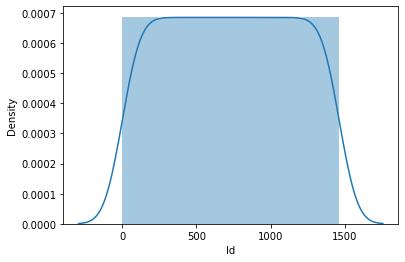

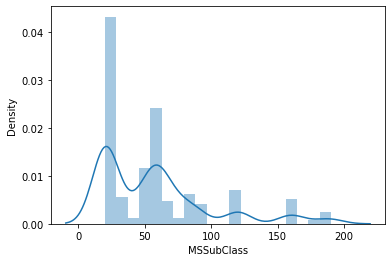

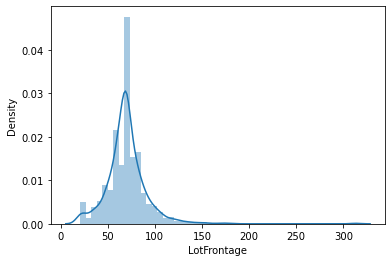

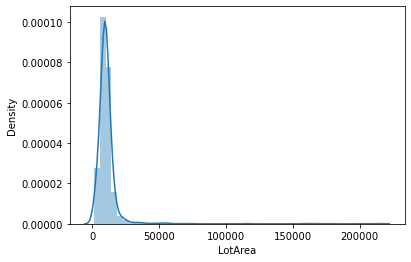

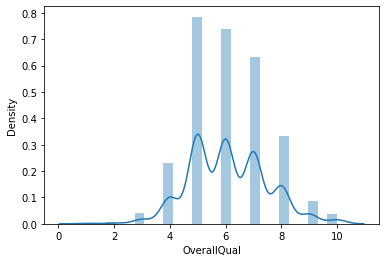

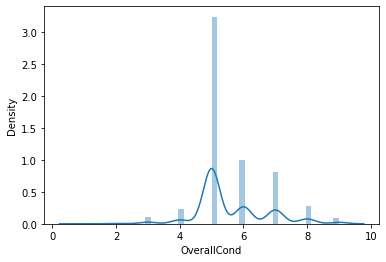

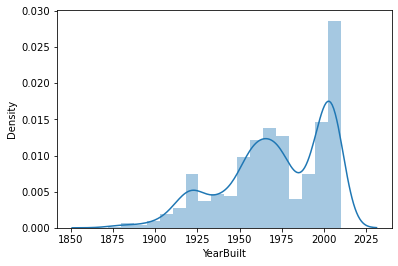

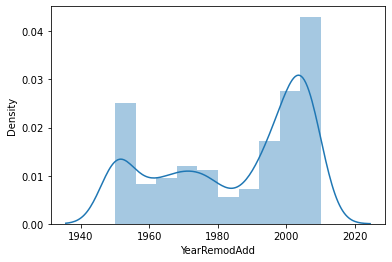

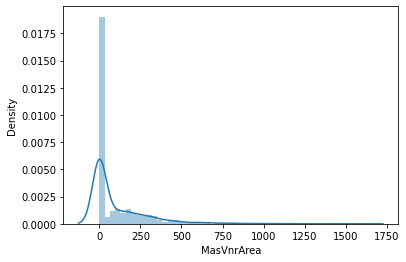

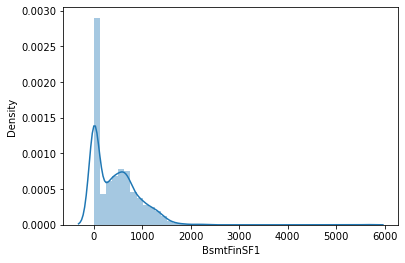

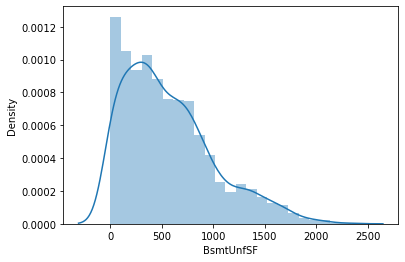

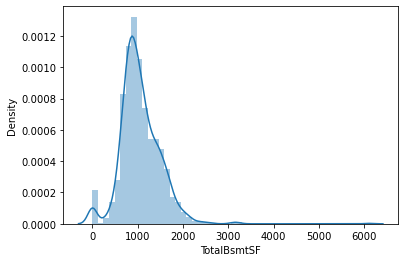

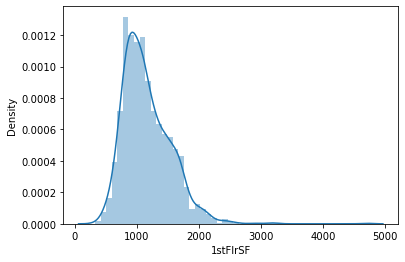

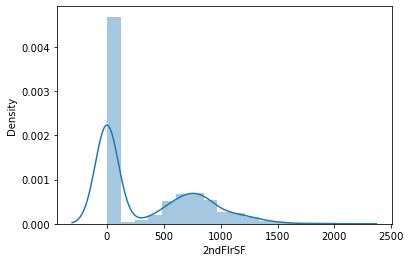

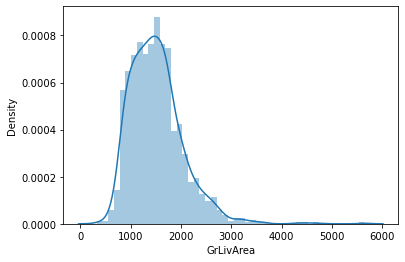

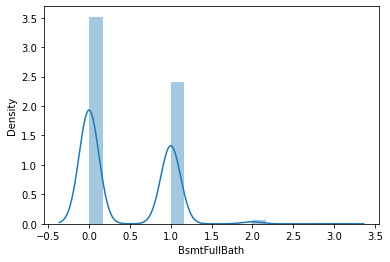

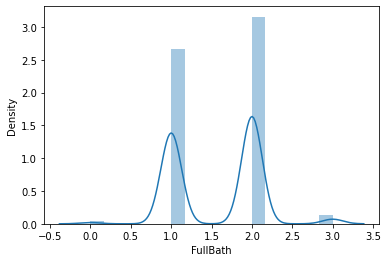

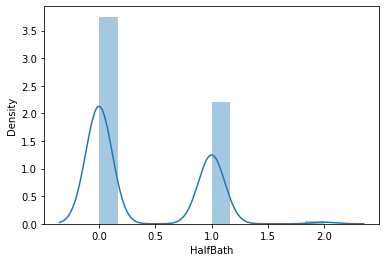

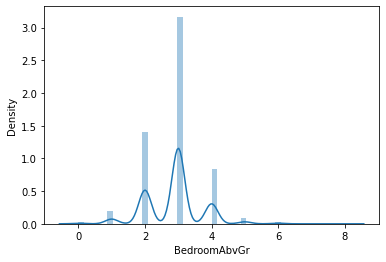

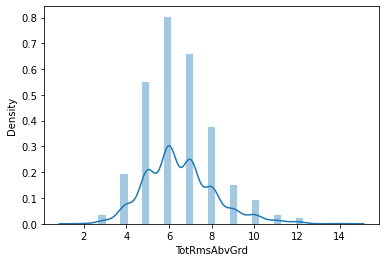

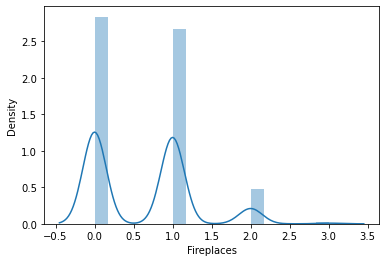

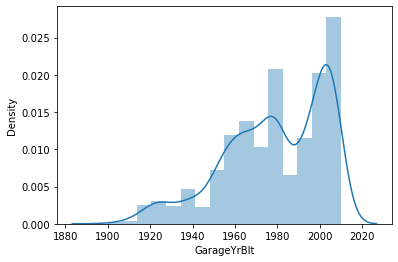

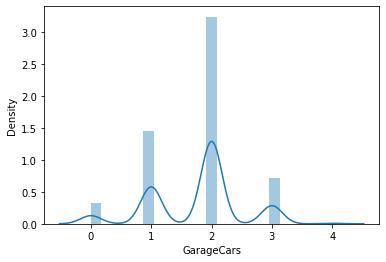

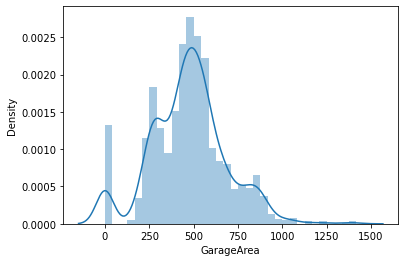

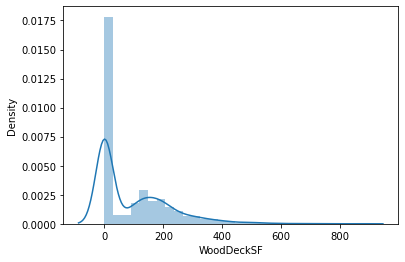

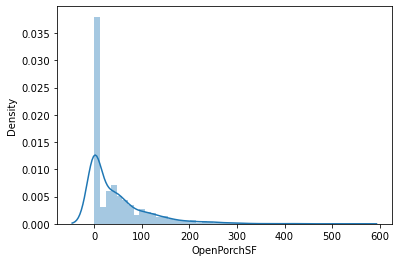

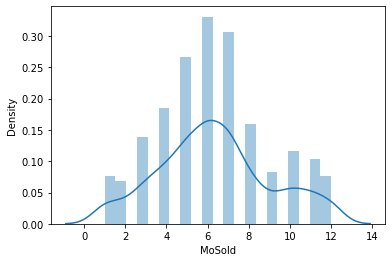

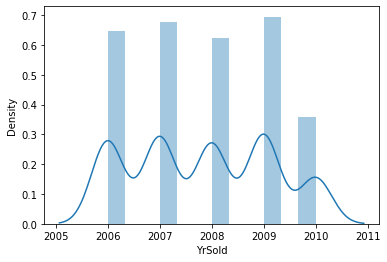

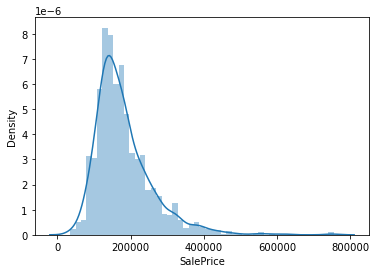

In [19]:

for numerical_variable in numerical_variables:
    sns.distplot(df[numerical_variable])
    plt.show()

In [20]:

for null_values_categorical_column in null_values_categorical_columns:
    mode = df[null_values_categorical_column].mode()[0]
    print("mode of {}: {}".format(null_values_categorical_column, mode))
    display(df[null_values_categorical_column].value_counts())
    display(df[null_values_categorical_column].isnull().sum())
    replacement_value = "None"
    print("replacing null values of {} with {}".format(
        null_values_categorical_column, replacement_value))
    df[null_values_categorical_column].fillna(replacement_value, inplace=True)

mode of MasVnrType: None


None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

8

replacing null values of MasVnrType with None
mode of GarageType: Attchd


Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

81

replacing null values of GarageType with None
mode of BsmtFinType1: Unf


Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

37

replacing null values of BsmtFinType1 with None
mode of GarageFinish: Unf


Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

81

replacing null values of GarageFinish with None
mode of BsmtExposure: No


No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

38

replacing null values of BsmtExposure with None
mode of FireplaceQu: Gd


Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

690

replacing null values of FireplaceQu with None
mode of BsmtQual: TA


TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

37

replacing null values of BsmtQual with None



## Data Preparation

In [21]:


df1 = df.drop(columns=['Id'])

# convert categorical variables to categorical type
for categorical_variable in categorical_variables:
    df1[categorical_variable] = pd.Categorical(df1[categorical_variable])

len(categorical_variables)

31

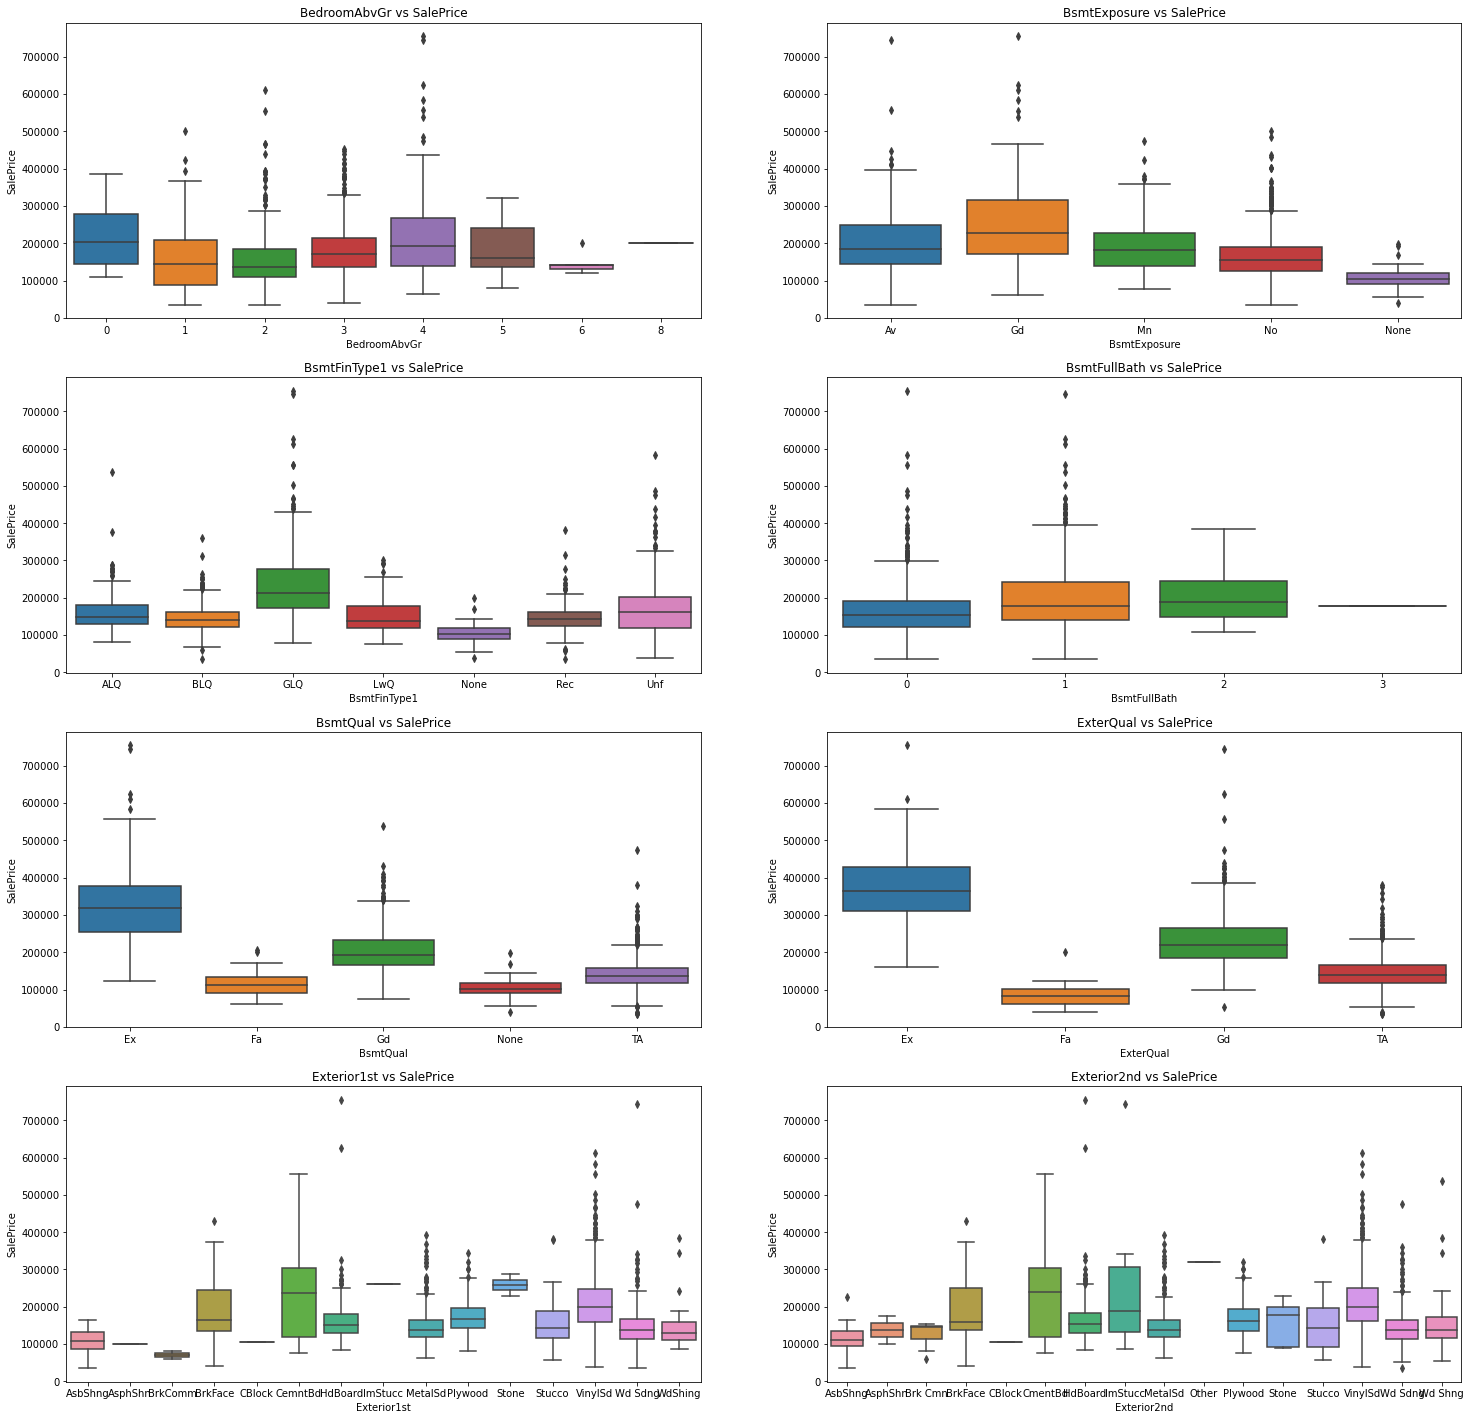

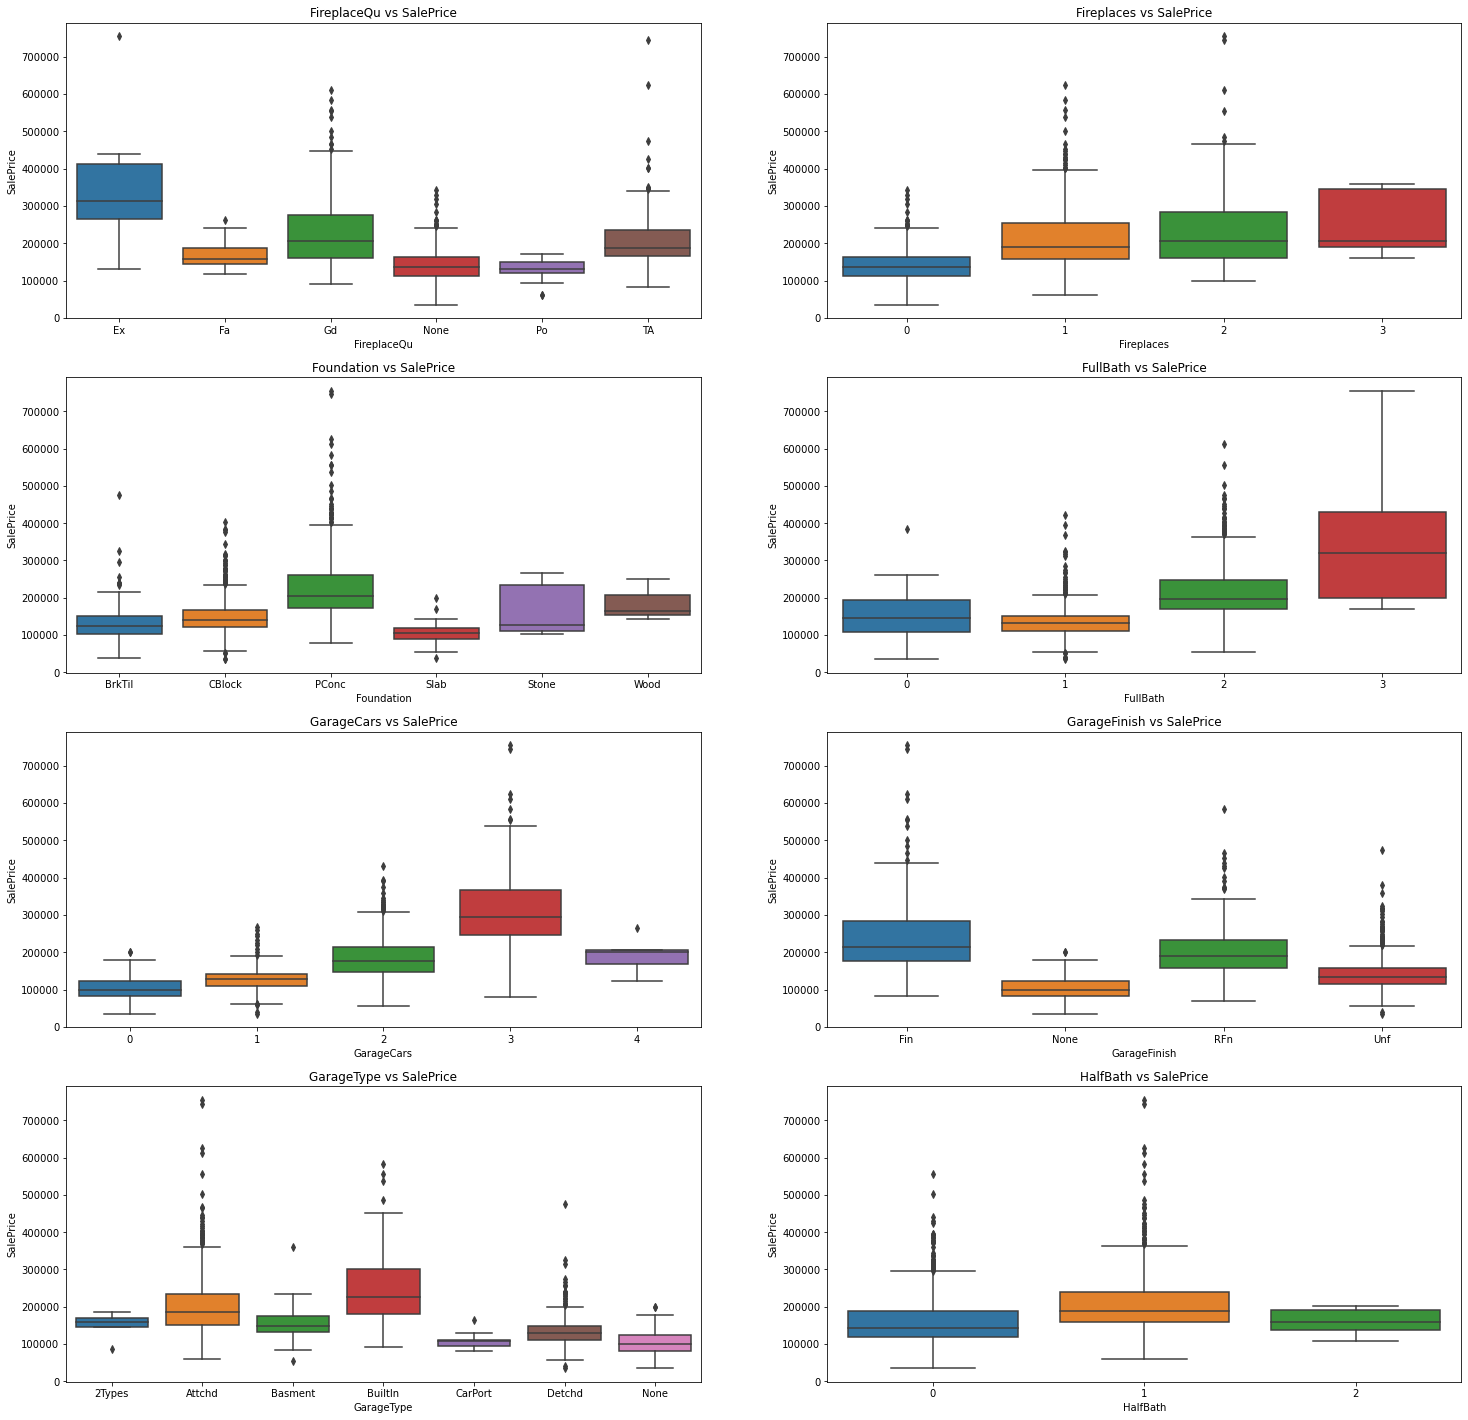

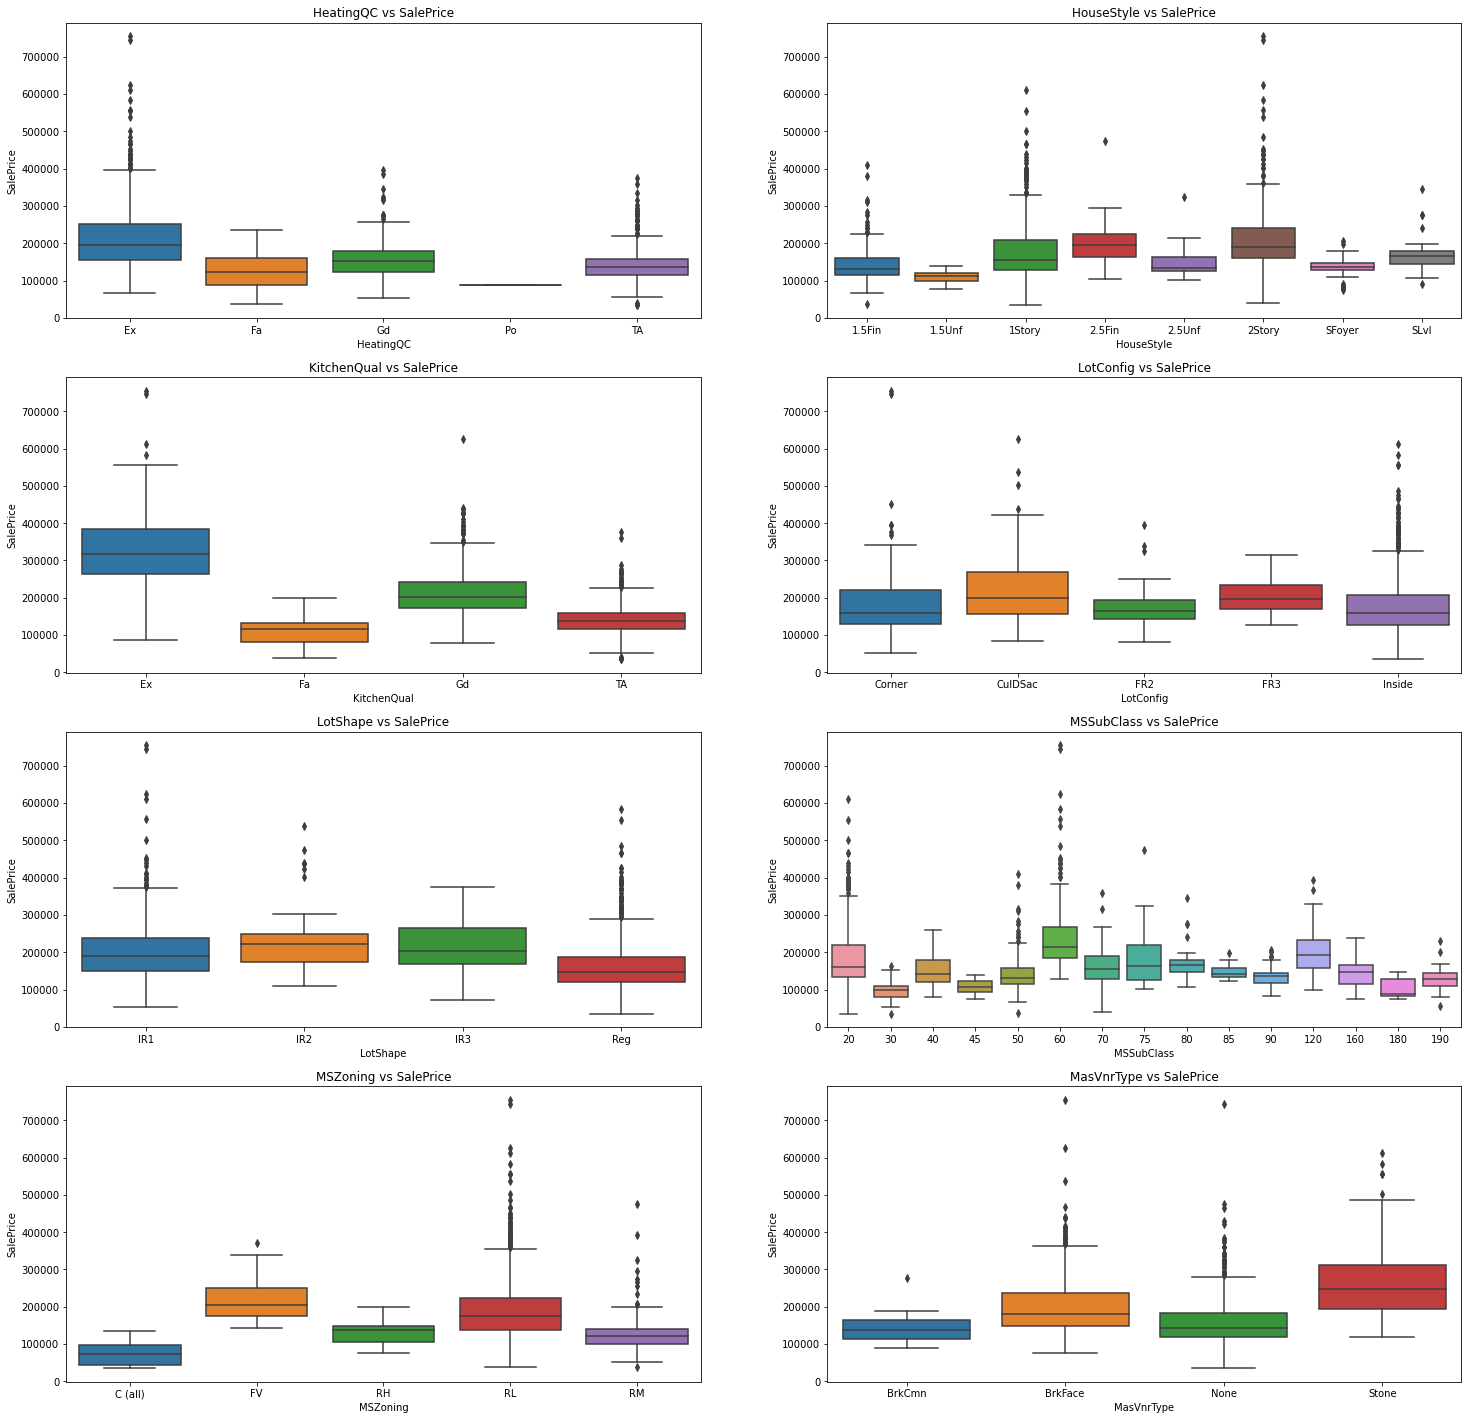

list index out of range


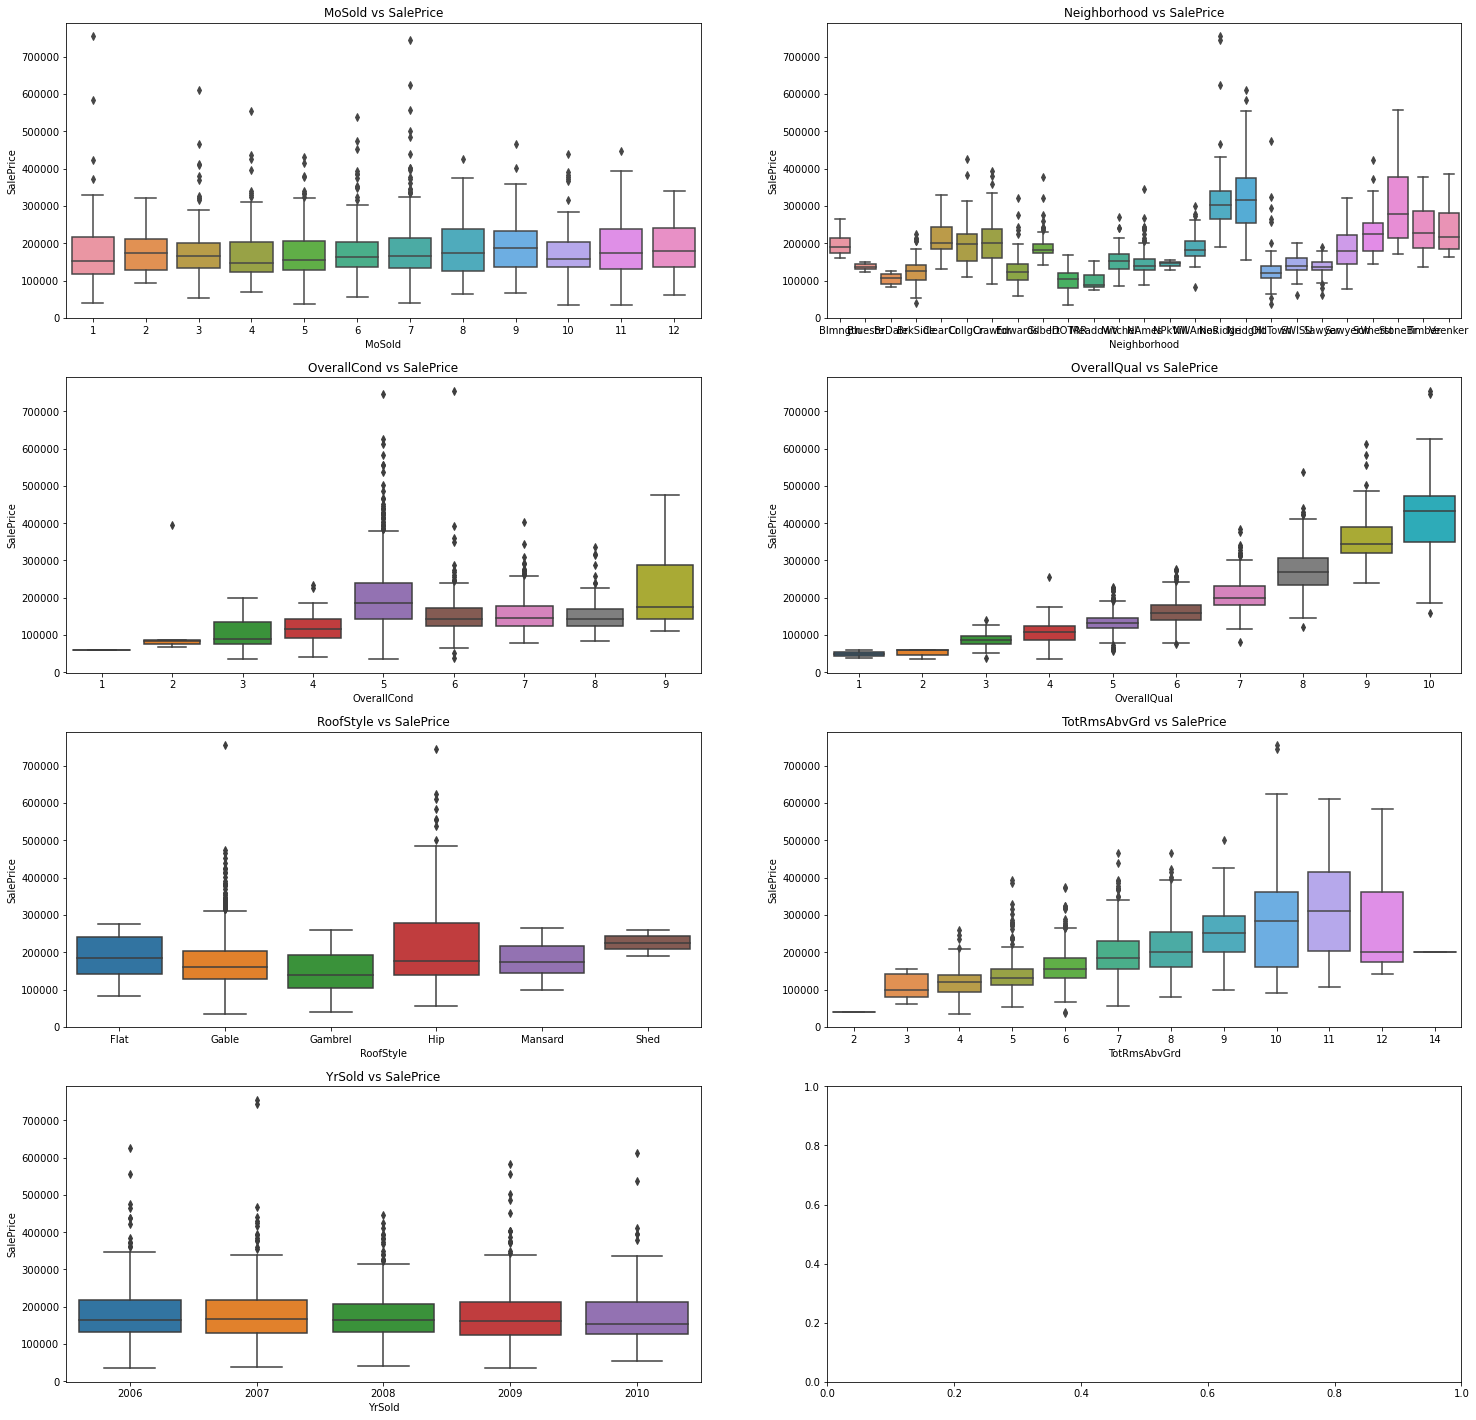

In [22]:


def categorical_vs_target_boxplot(df1, target):

    range_elements = range(1, 9)
    length = len(range_elements)

    for i in range(0, len(categorical_variables), length):
        plt.figure(figsize=(25, 25))
        for k in range_elements:
            cat_variable_num = i + k - 1
            # print(cat_variable_num)
            plt.subplot(4, 2, k)
            try:
                sns.boxplot(
                    x=categorical_variables[cat_variable_num], y=target, data=df1)
                plt.title(
                    categorical_variables[cat_variable_num] + f' vs {target}')
            except Exception as e:
                print(e)
        plt.show()


categorical_vs_target_boxplot(df1, 'SalePrice')

BedroomAbvGr


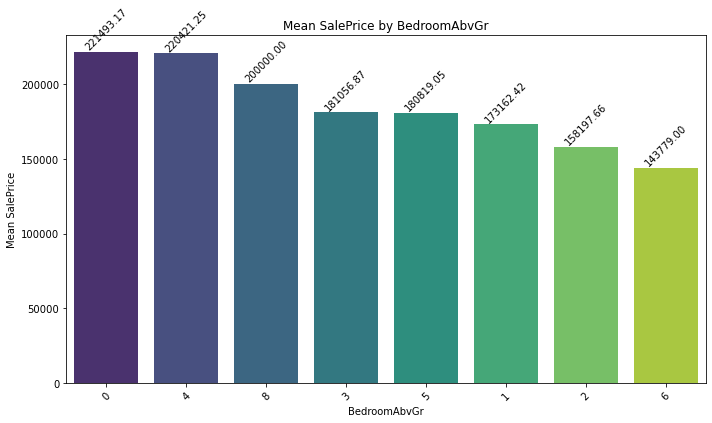

No description found for BedroomAbvGr in data dictionary



BsmtExposure


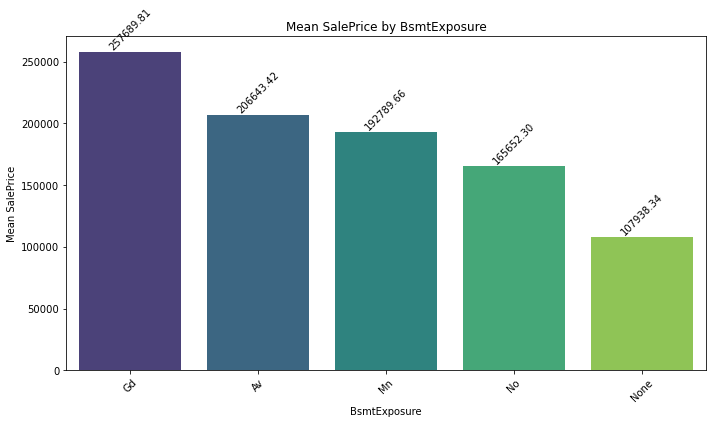

BsmtExposure {'description': ' Refers to walkout or garden level walls', 'values': '\n       Ex\tExcellent\n       Gd\tGood\n       TA\tTypical - slight dampness allowed\n       Fa\tFair - dampness or some cracking or settling\n       Po\tPoor - Severe cracking, settling, or wetness\n       NA\tNo Basement\n\t'}



BsmtFinType1


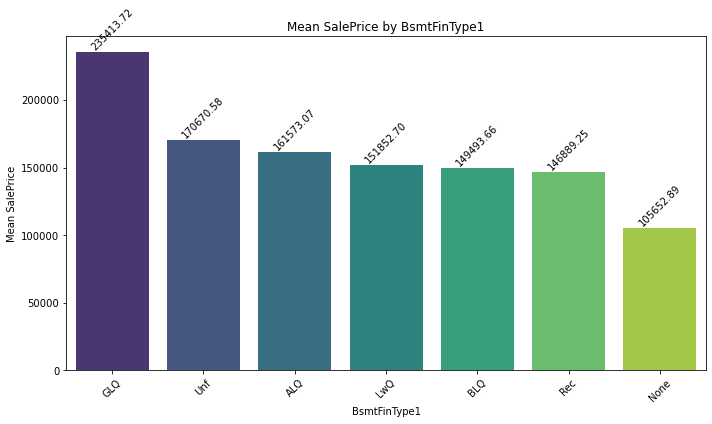

BsmtFinType1 {'description': ' Rating of basement finished area', 'values': '\n       Gd\tGood Exposure\n       Av\tAverage Exposure (split levels or foyers typically score average or above)\t\n       Mn\tMimimum Exposure\n       No\tNo Exposure\n       NA\tNo Basement\n\t'}



BsmtFullBath


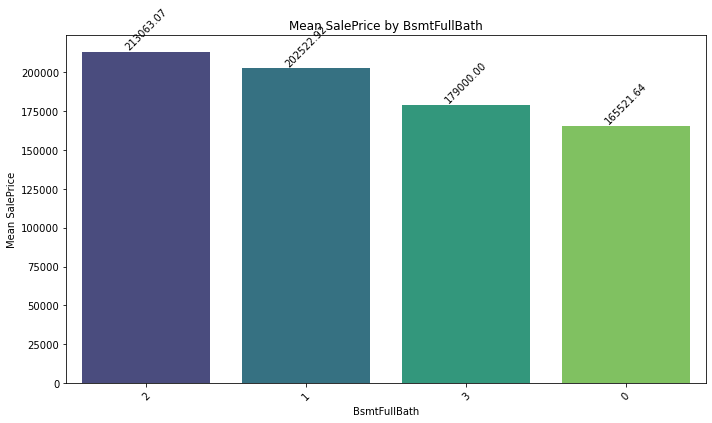

BsmtFullBath {'description': ' Basement full bathrooms', 'values': ''}



BsmtQual


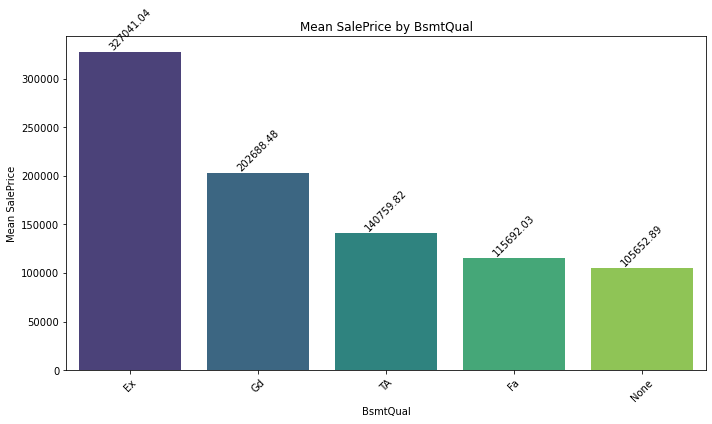

BsmtQual {'description': ' Evaluates the height of the basement', 'values': '\t\t\n       BrkTil\tBrick & Tile\n       CBlock\tCinder Block\n       PConc\tPoured Contrete\t\n       Slab\tSlab\n       Stone\tStone\n       Wood\tWood\n\t\t'}



ExterQual


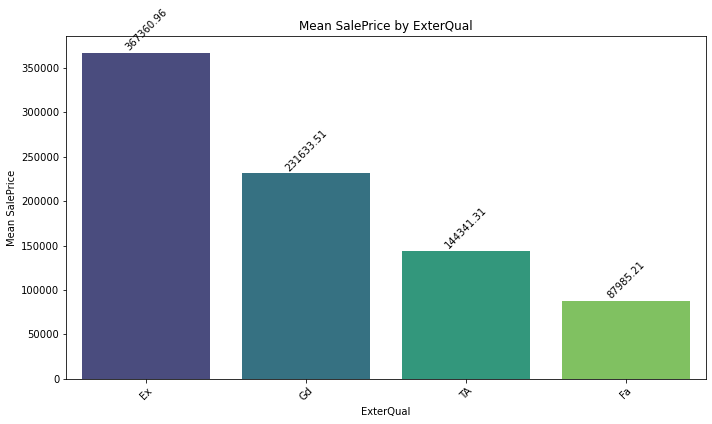

ExterQual {'description': ' Evaluates the quality of the material on the exterior ', 'values': ''}



Exterior1st


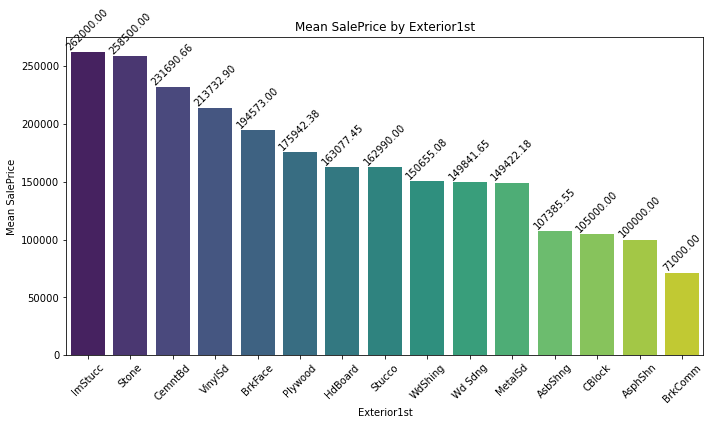

Exterior1st {'description': ' Exterior covering on house', 'values': '\n       ClyTile\tClay or Tile\n       CompShg\tStandard (Composite) Shingle\n       Membran\tMembrane\n       Metal\tMetal\n       Roll\tRoll\n       Tar&Grv\tGravel & Tar\n       WdShake\tWood Shakes\n       WdShngl\tWood Shingles\n\t\t'}



Exterior2nd


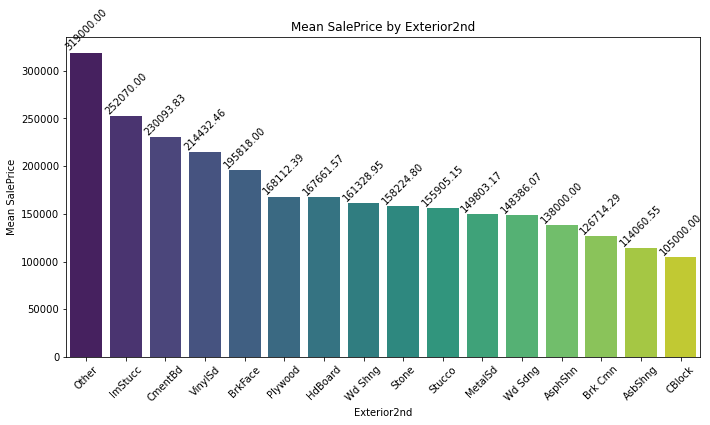

Exterior2nd {'description': ' Exterior covering on house (if more than one material)', 'values': '\n       AsbShng\tAsbestos Shingles\n       AsphShn\tAsphalt Shingles\n       BrkComm\tBrick Common\n       BrkFace\tBrick Face\n       CBlock\tCinder Block\n       CemntBd\tCement Board\n       HdBoard\tHard Board\n       ImStucc\tImitation Stucco\n       MetalSd\tMetal Siding\n       Other\tOther\n       Plywood\tPlywood\n       PreCast\tPreCast\t\n       Stone\tStone\n       Stucco\tStucco\n       VinylSd\tVinyl Siding\n       Wd Sdng\tWood Siding\n       WdShing\tWood Shingles\n\t'}



FireplaceQu


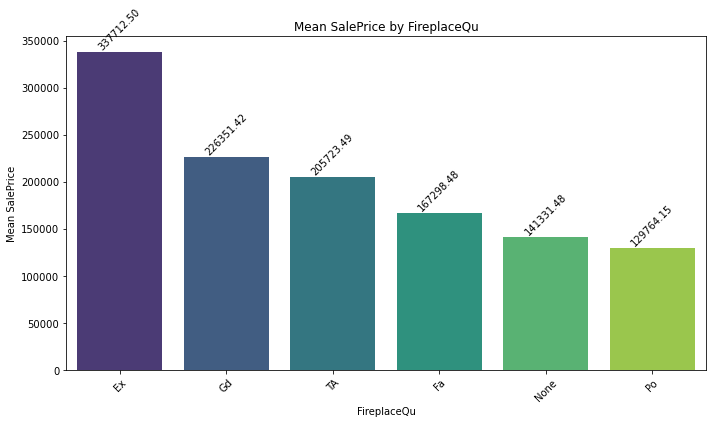

FireplaceQu {'description': ' Fireplace quality', 'values': ''}



Fireplaces


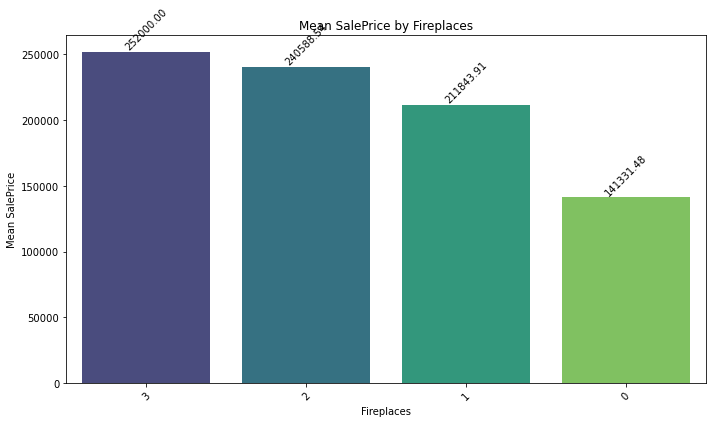

Fireplaces {'description': ' Number of fireplaces', 'values': '\n       Typ\tTypical Functionality\n       Min1\tMinor Deductions 1\n       Min2\tMinor Deductions 2\n       Mod\tModerate Deductions\n       Maj1\tMajor Deductions 1\n       Maj2\tMajor Deductions 2\n       Sev\tSeverely Damaged\n       Sal\tSalvage only\n\t\t'}



Foundation


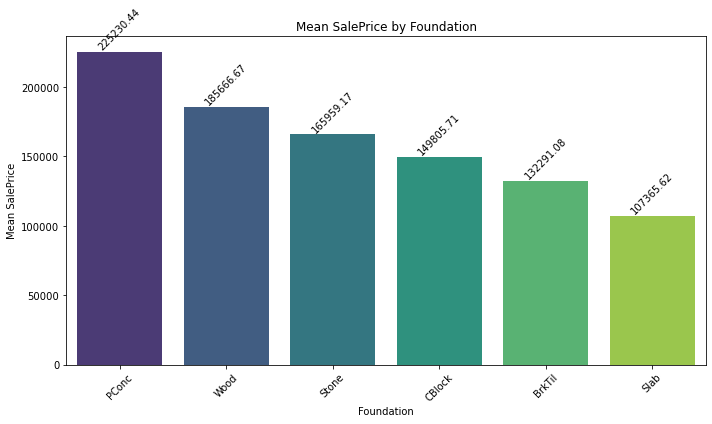

Foundation {'description': ' Type of foundation', 'values': '\t\t\n       Ex\tExcellent\n       Gd\tGood\n       TA\tAverage/Typical\n       Fa\tFair\n       Po\tPoor\n\t\t'}



FullBath


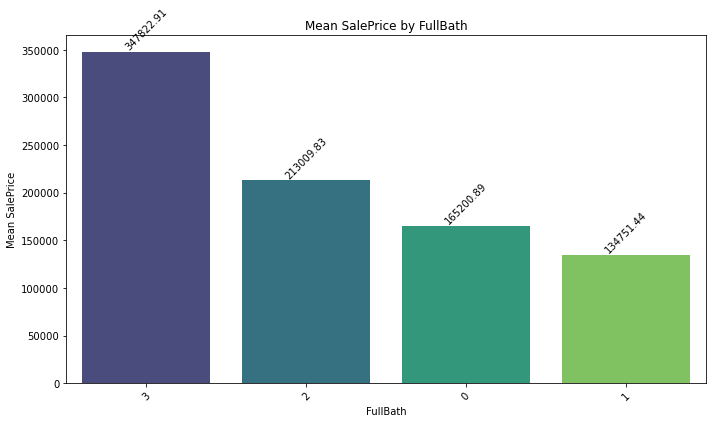

FullBath {'description': ' Full bathrooms above grade', 'values': ''}



GarageCars


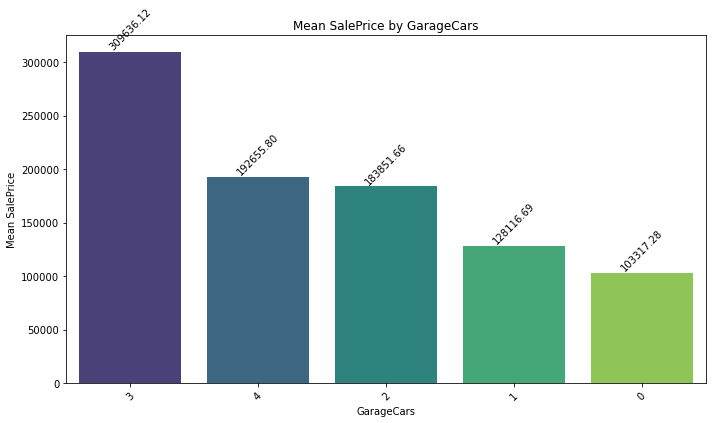

GarageCars {'description': ' Size of garage in car capacity', 'values': '\n       Fin\tFinished\n       RFn\tRough Finished\t\n       Unf\tUnfinished\n       NA\tNo Garage\n\t\t'}



GarageFinish


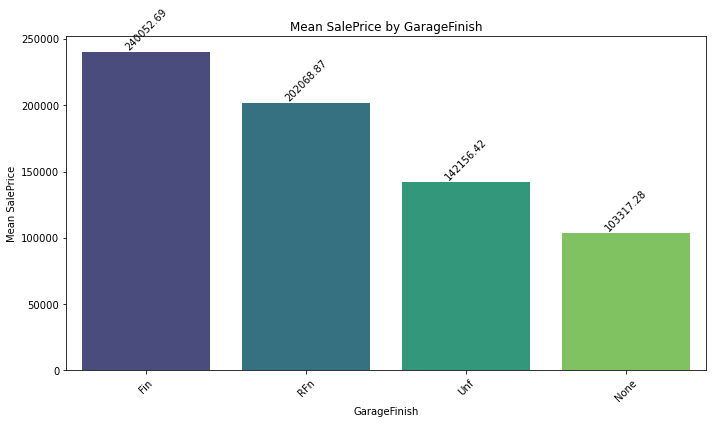

GarageFinish {'description': ' Interior finish of the garage', 'values': '\t\t'}



GarageType


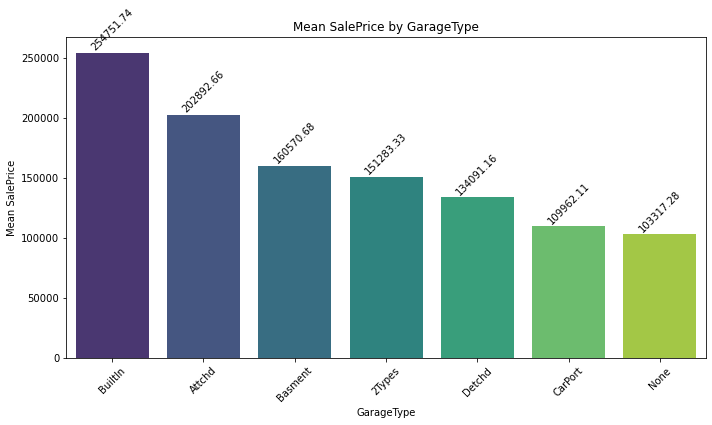

GarageType {'description': ' Garage location', 'values': '\n       Ex\tExcellent - Exceptional Masonry Fireplace\n       Gd\tGood - Masonry Fireplace in main level\n       TA\tAverage - Prefabricated Fireplace in main living area or Masonry Fireplace in basement\n       Fa\tFair - Prefabricated Fireplace in basement\n       Po\tPoor - Ben Franklin Stove\n       NA\tNo Fireplace\n\t\t'}



HalfBath


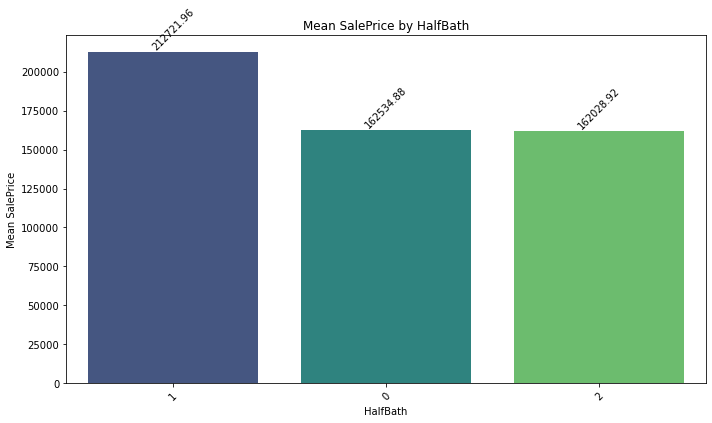

HalfBath {'description': ' Half baths above grade', 'values': ''}



HeatingQC


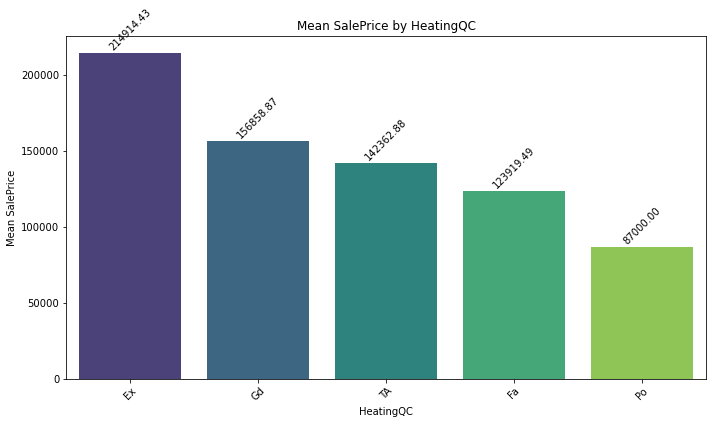

HeatingQC {'description': ' Heating quality and condition', 'values': '\t\t\n       Floor\tFloor Furnace\n       GasA\tGas forced warm air furnace\n       GasW\tGas hot water or steam heat\n       Grav\tGravity furnace\t\n       OthW\tHot water or steam heat other than gas\n       Wall\tWall furnace\n\t\t'}



HouseStyle


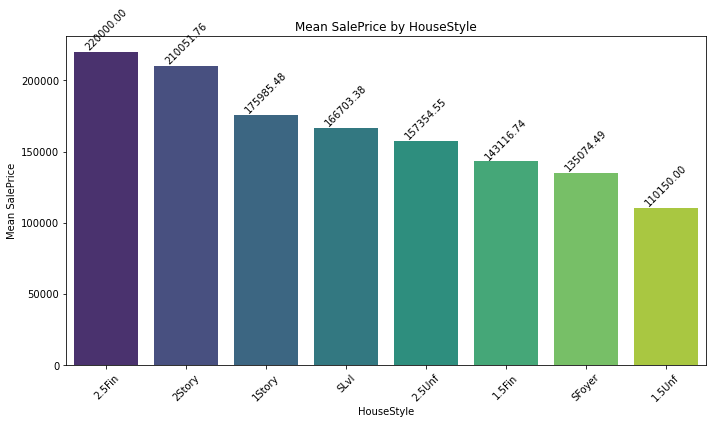

HouseStyle {'description': ' Style of dwelling', 'values': '\t\t\n       1Fam\tSingle-family Detached\t\n       2FmCon\tTwo-family Conversion; originally built as one-family dwelling\n       Duplx\tDuplex\n       TwnhsE\tTownhouse End Unit\n       TwnhsI\tTownhouse Inside Unit\n\t'}



KitchenQual


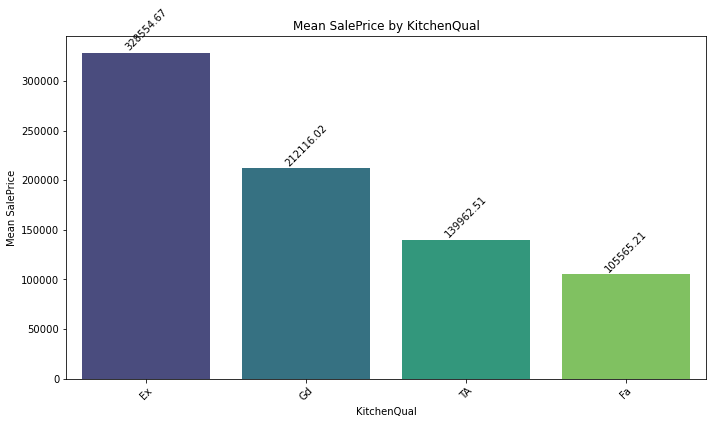

KitchenQual {'description': ' Kitchen quality', 'values': ''}



LotConfig


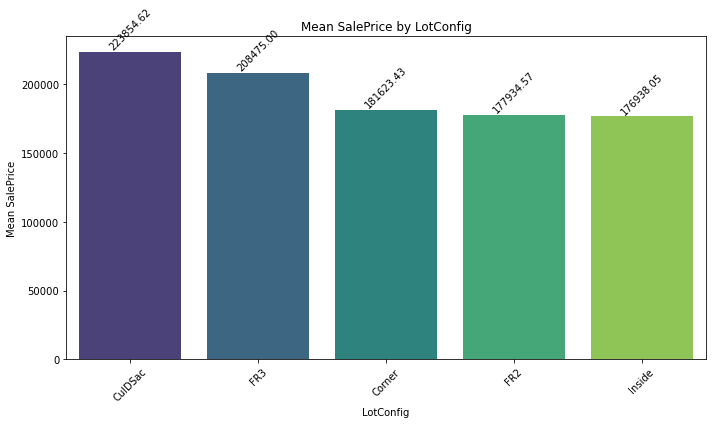

LotConfig {'description': ' Lot configuration', 'values': '\t\t\n       AllPub\tAll public Utilities (E,G,W,& S)\t\n       NoSewr\tElectricity, Gas, and Water (Septic Tank)\n       NoSeWa\tElectricity and Gas Only\n       ELO\tElectricity only\t\n\t'}



LotShape


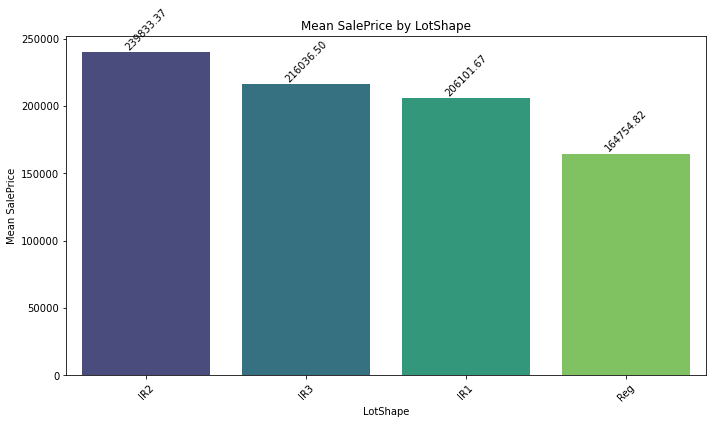

LotShape {'description': ' General shape of property', 'values': '\n       Grvl\tGravel\n       Pave\tPaved\n       NA \tNo alley access\n\t\t'}



MSSubClass


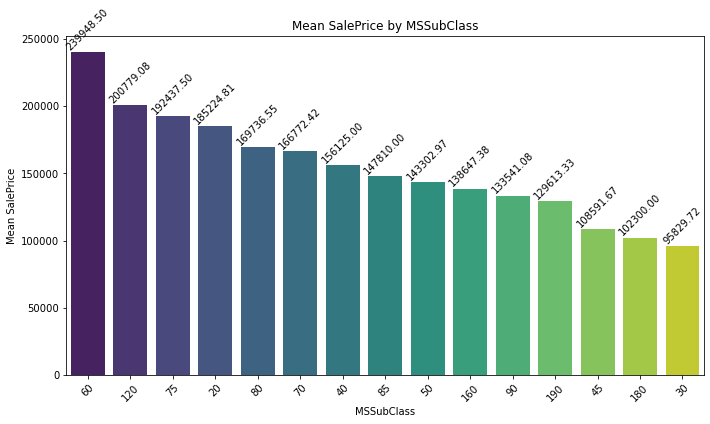

MSSubClass {'description': ' Identifies the type of dwelling involved in the sale.\t'}



MSZoning


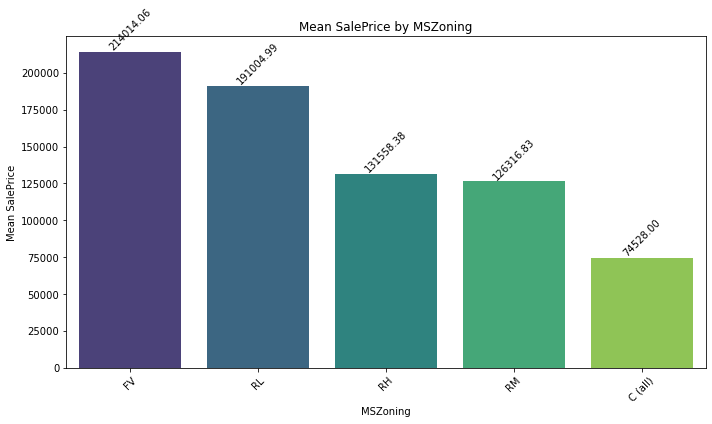

MSZoning {'description': ' Identifies the general zoning classification of the sale.', 'values': '\n        20\t1-STORY 1946 & NEWER ALL STYLES\n        30\t1-STORY 1945 & OLDER\n        40\t1-STORY W/FINISHED ATTIC ALL AGES\n        45\t1-1/2 STORY - UNFINISHED ALL AGES\n        50\t1-1/2 STORY FINISHED ALL AGES\n        60\t2-STORY 1946 & NEWER\n        70\t2-STORY 1945 & OLDER\n        75\t2-1/2 STORY ALL AGES\n        80\tSPLIT OR MULTI-LEVEL\n        85\tSPLIT FOYER\n        90\tDUPLEX - ALL STYLES AND AGES\n       120\t1-STORY PUD (Planned Unit Development) - 1946 & NEWER\n       150\t1-1/2 STORY PUD - ALL AGES\n       160\t2-STORY PUD - 1946 & NEWER\n       180\tPUD - MULTILEVEL - INCL SPLIT LEV/FOYER\n       190\t2 FAMILY CONVERSION - ALL STYLES AND AGES\n'}



MasVnrType


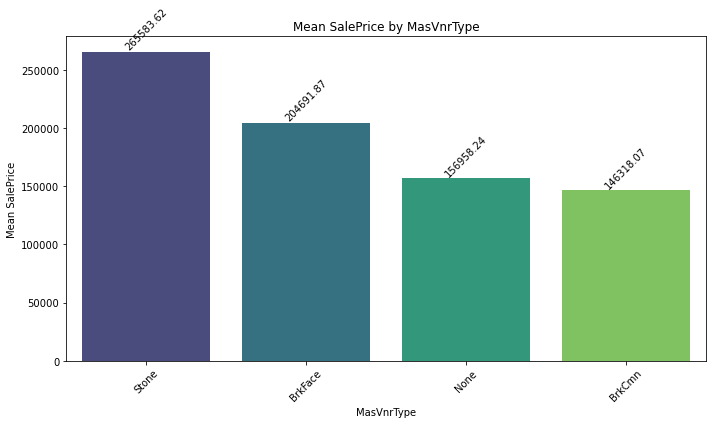

MasVnrType {'description': ' Masonry veneer type', 'values': '\n       AsbShng\tAsbestos Shingles\n       AsphShn\tAsphalt Shingles\n       BrkComm\tBrick Common\n       BrkFace\tBrick Face\n       CBlock\tCinder Block\n       CemntBd\tCement Board\n       HdBoard\tHard Board\n       ImStucc\tImitation Stucco\n       MetalSd\tMetal Siding\n       Other\tOther\n       Plywood\tPlywood\n       PreCast\tPreCast\n       Stone\tStone\n       Stucco\tStucco\n       VinylSd\tVinyl Siding\n       Wd Sdng\tWood Siding\n       WdShing\tWood Shingles\n\t'}



MoSold


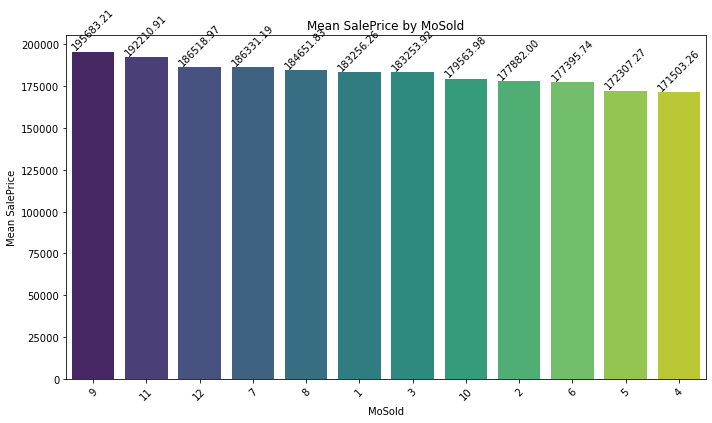

MoSold {'description': ' Month Sold (MM)', 'values': ''}



Neighborhood


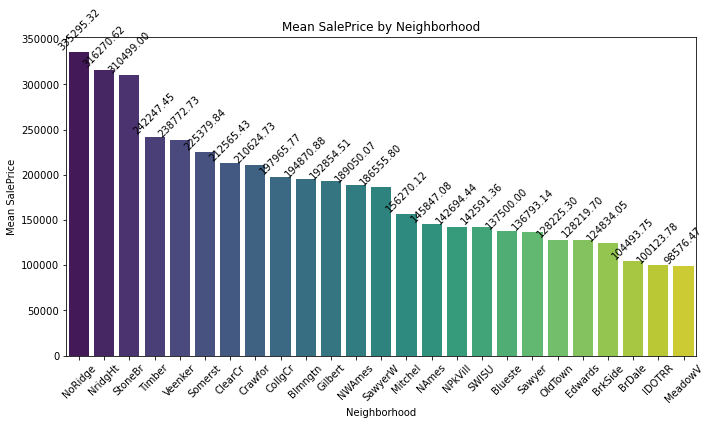

Neighborhood {'description': ' Physical locations within Ames city limits', 'values': '\t\t\n       Gtl\tGentle slope\n       Mod\tModerate Slope\t\n       Sev\tSevere Slope\n\t'}



OverallCond


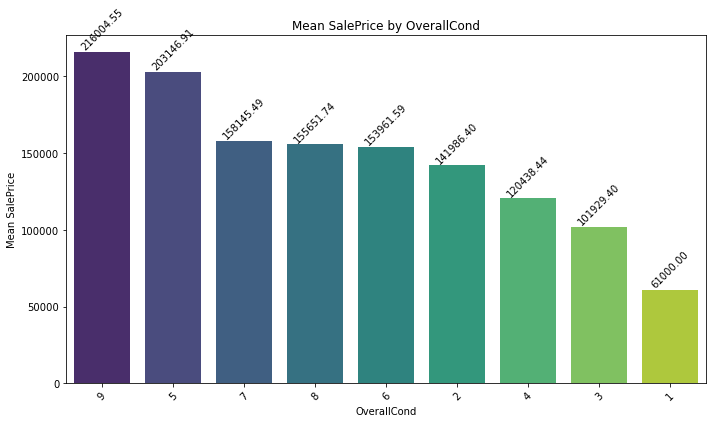

OverallCond {'description': ' Rates the overall condition of the house', 'values': '\n       10\tVery Excellent\n       9\tExcellent\n       8\tVery Good\n       7\tGood\n       6\tAbove Average\n       5\tAverage\n       4\tBelow Average\n       3\tFair\n       2\tPoor\n       1\tVery Poor\n\t'}



OverallQual


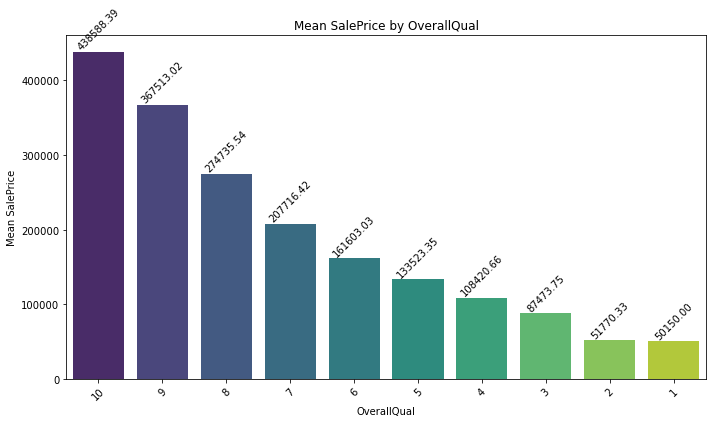

OverallQual {'description': ' Rates the overall material and finish of the house', 'values': '\t\n       1Story\tOne story\n       1.5Fin\tOne and one-half story: 2nd level finished\n       1.5Unf\tOne and one-half story: 2nd level unfinished\n       2Story\tTwo story\n       2.5Fin\tTwo and one-half story: 2nd level finished\n       2.5Unf\tTwo and one-half story: 2nd level unfinished\n       SFoyer\tSplit Foyer\n       SLvl\tSplit Level\n\t'}



RoofStyle


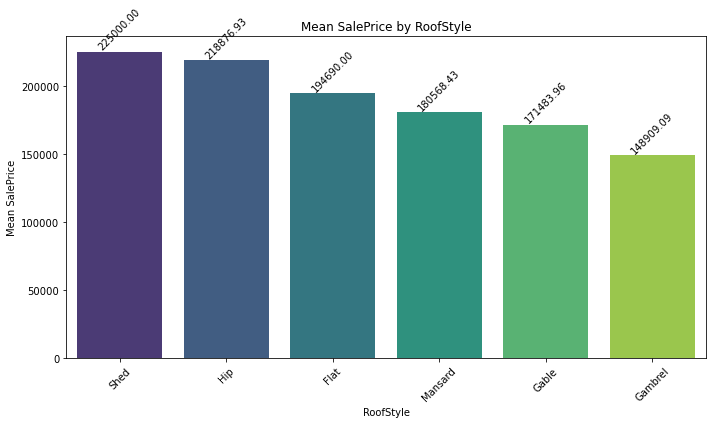

RoofStyle {'description': ' Type of roof', 'values': ''}



TotRmsAbvGrd


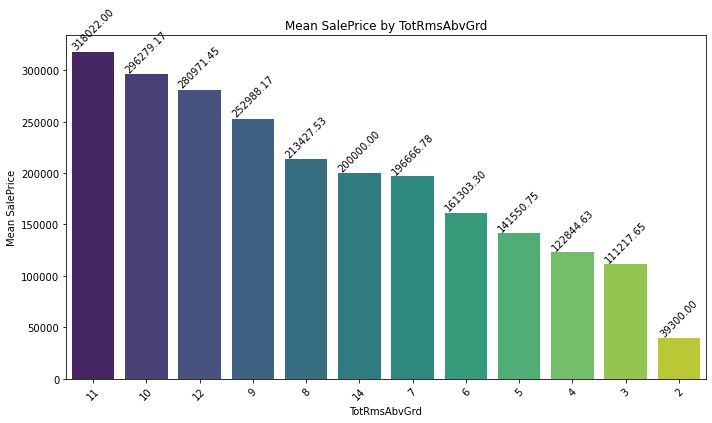

TotRmsAbvGrd {'description': ' Total rooms above grade (does not include bathrooms)', 'values': '\n       Ex\tExcellent\n       Gd\tGood\n       TA\tTypical/Average\n       Fa\tFair\n       Po\tPoor\n       \t'}



YrSold


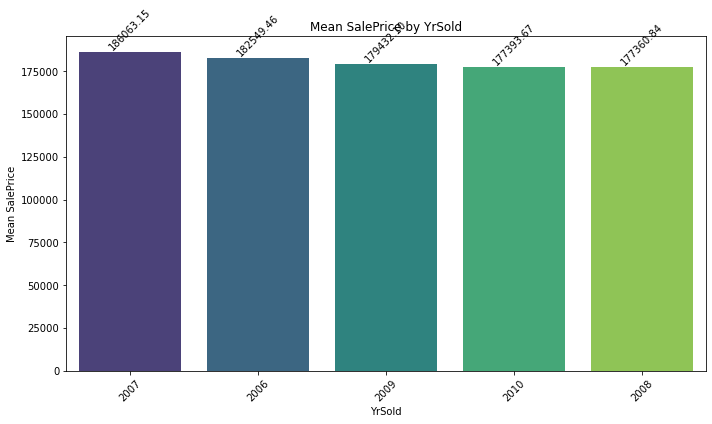

YrSold {'description': ' Year Sold (YYYY)', 'values': ''}





In [23]:


def categorical_vs_target_barplot(df1, categorical_variable, target):
    # Grouping by 'categorical_variable' and calculating mean SalePrice, then sorting values
    mean_prices = df1.groupby(categorical_variable)[
        target].mean().sort_values(ascending=False)
    # print(mean_prices)
    # Creating a bar plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mean_prices.index, y=mean_prices.values,
                palette='viridis', order=mean_prices.index)

    # Annotating mean values on top of each bar
    for i, value in enumerate(mean_prices):
        plt.text(i, value, f'{value:.2f}',
                 ha='center', va='bottom', rotation=45)

    plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
    plt.xlabel(categorical_variable)
    plt.ylabel(f'Mean {target}')
    plt.title(f'Mean {target} by {categorical_variable}')
    plt.tight_layout()
    plt.show()
    if categorical_variable in data_dictionary:
        print(categorical_variable, data_dictionary[categorical_variable])
    else:
        print("No description found for {} in data dictionary".format(
            categorical_variable))


for categorical_variable in categorical_variables:
    print(categorical_variable)
    categorical_vs_target_barplot(df1, categorical_variable, 'SalePrice')
    print("\n\n")

In [24]:

# some categorical variables identified were actually numerical variables
# convert them to numerical variables

# numerical_variables = numerical_variables + ['3SsnPorch', 'LowQualFinSF', 'PoolArea']
# categorical_variables = list(set(categorical_variables) - set(['3SsnPorch', 'LowQualFinSF', 'PoolArea']))

In [25]:


data = df

# Assuming 'categorical_var' is the column name of your categorical variable

num_features_to_rfe_info_mapping = {}
categoricals = []
f_statistics = []
p_values = []
for categorical_var in categorical_variables:
    # Assuming 'numerical_var' is the column name of your numerical variable
    numerical_var = 'SalePrice'

    # Perform ANOVA
    grouped_data = [data[numerical_var][data[categorical_var] == category]
                    for category in data[categorical_var].unique()]
    f_stat, p_value = f_oneway(*grouped_data)

    # Output the results
    # print(f" {categorical_var} F-statistic: {f_stat} P-value: {p_value}")
    categoricals.append(categorical_var)
    f_statistics.append(f_stat)
    p_values.append(p_value)

num_features_to_rfe_info_mapping = {
    "categorical": categoricals, "f_statistic": f_statistics, "p_value": p_values}
f_st_df = pd.DataFrame(num_features_to_rfe_info_mapping).sort_values(
    by=["f_statistic"], ascending=True)

sorted_by_f_st = f_st_df[f_st_df["p_value"] < 0.05].sort_values(
    by=["f_statistic"], ascending=False)
sorted_by_f_st

,categorical,f_statistic,p_value
5,ExterQual,443.334831,1.439551e-204
18,KitchenQual,407.806352,3.032213e-192
12,GarageCars,351.207486,1.121129e-211
27,OverallQual,349.026840,0.000000e+00
4,BsmtQual,316.148635,8.158548e-196
11,FullBath,246.067004,3.802188e-129
13,GarageFinish,213.867028,6.228747e-115
9,Fireplaces,146.741176,4.421001e-83
8,FireplaceQu,121.075121,2.971217e-107
23,MasVnrType,108.911305,1.279704e-63


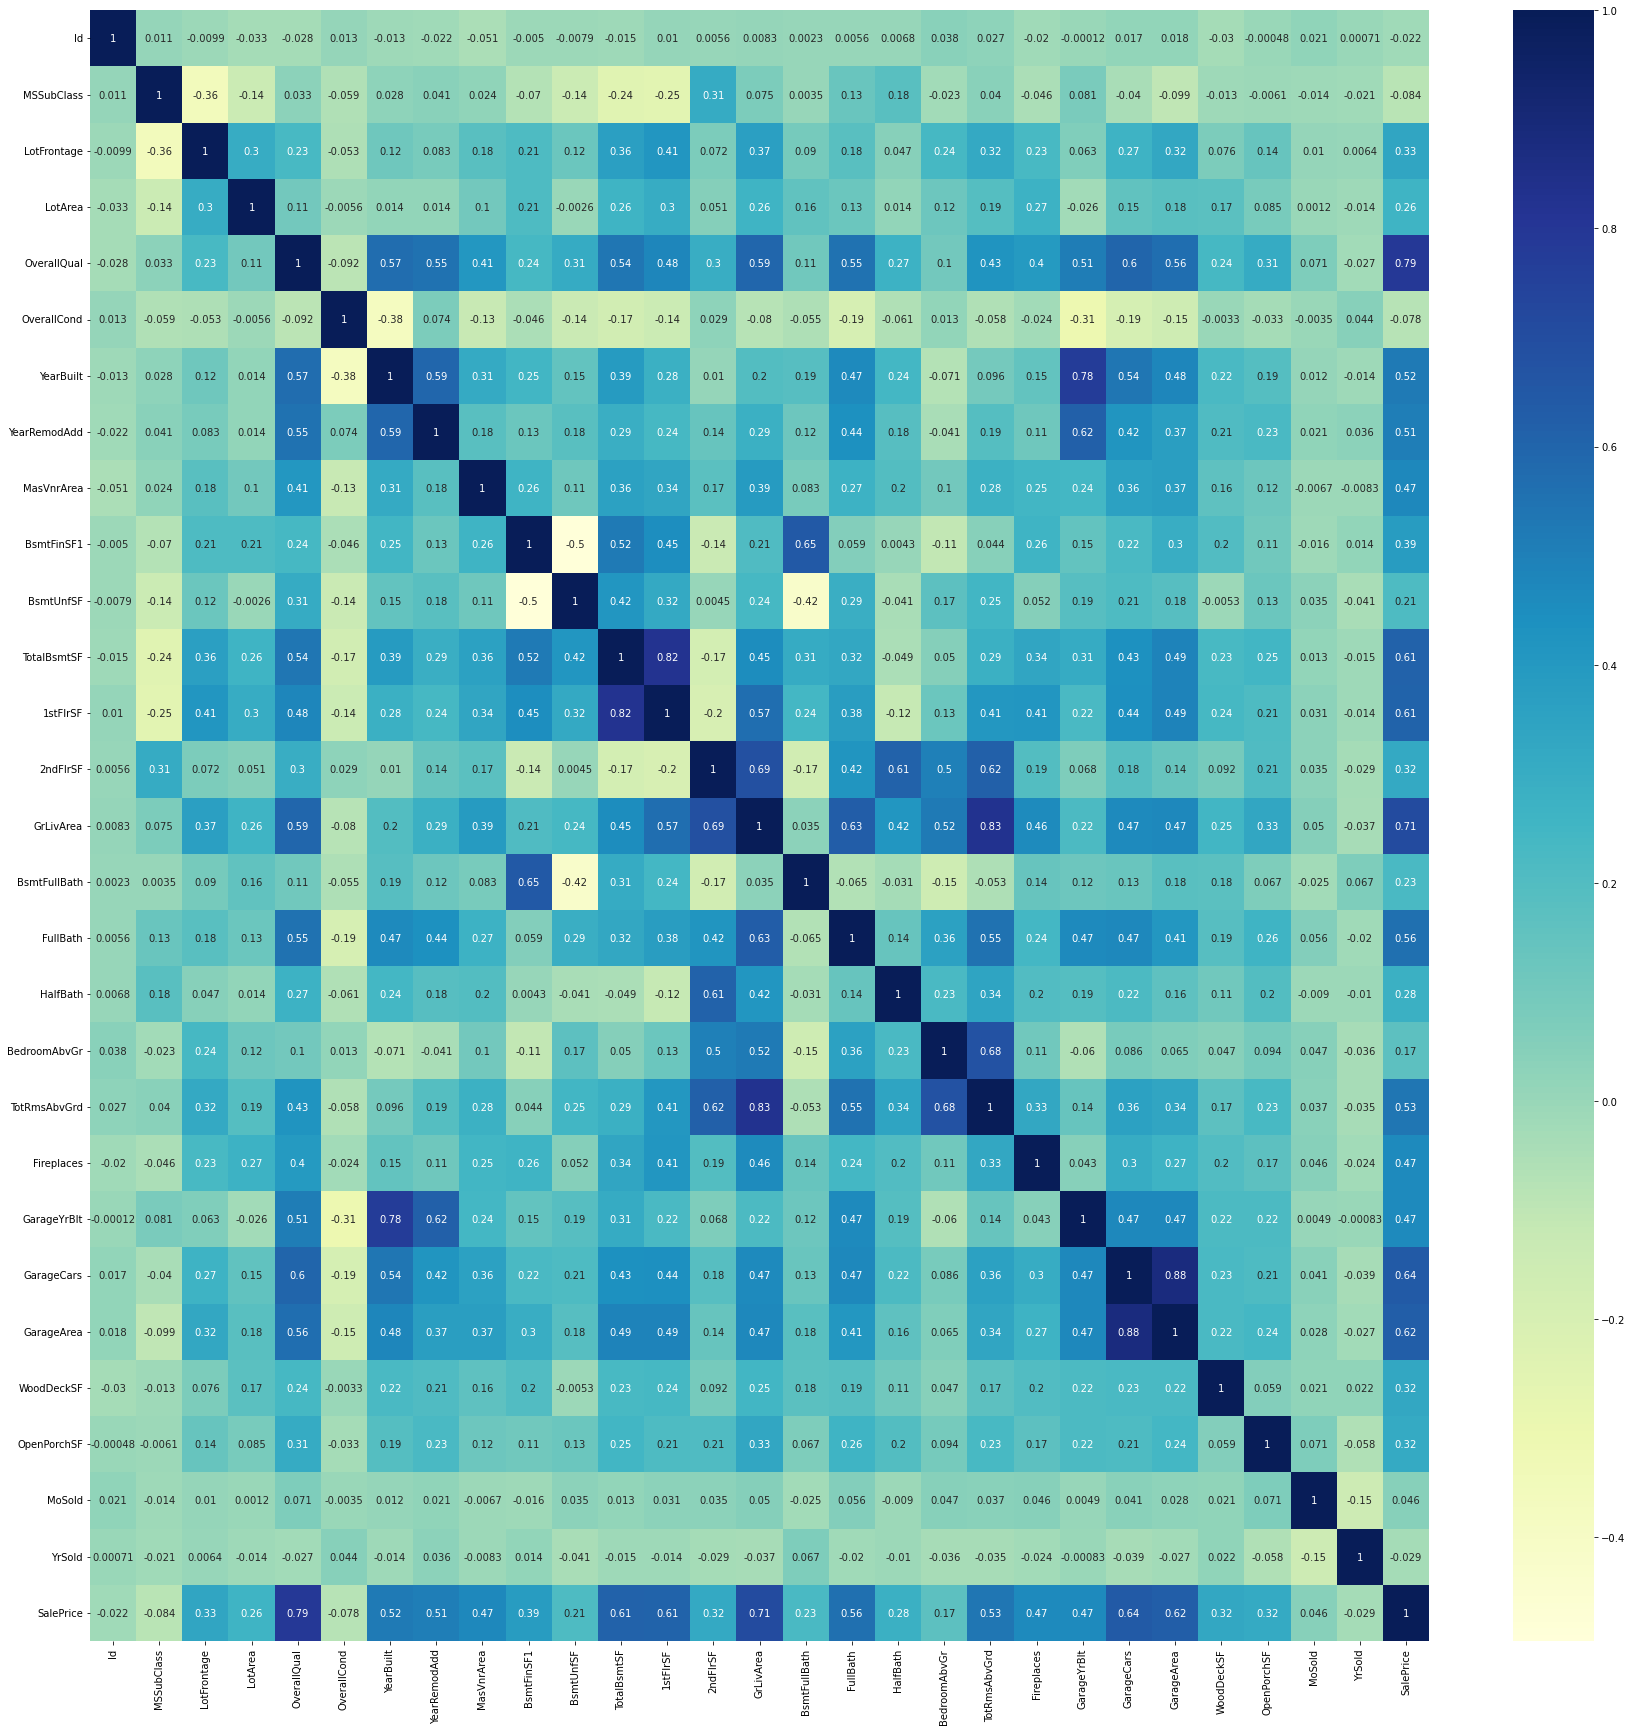

In [26]:

corr = df[numerical_variables].corr()

# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(30, 30))

# heatmap
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

In [27]:

corr1 = corr['SalePrice'].sort_values(ascending=False)

print("Negative Correlations:")
display(corr1[corr1 < 0])

threshold = 0.5
print("Top 10 Positive Correlations greater than {}:".format(threshold))
display(corr1[corr1 > threshold])

indices = corr1[corr1 > threshold].index


def highlight(corr, threshold_low, threshold_high, color):
    # Apply styling to the correlation matrix 'corr'
    return corr.style.apply(
        # Lambda function to apply background color 'red' if value 'v' in row 'x' is greater than 'threshold', else no styling
        lambda x: [f"background: {color}" if v >
                   threshold_low and v < threshold_high else "" for v in x],
        axis=1  # Apply the function along rows (axis=1)
    )


display(highlight(corr.loc[indices, indices], .8, 1, 'red'))
highlight(corr.loc[indices, indices], .7, .8, 'yellow')

Negative Correlations:


Id            -0.021917
YrSold        -0.028923
OverallCond   -0.077856
MSSubClass    -0.084284
Name: SalePrice, dtype: float64

Top 10 Positive Correlations greater than 0.5:


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
SalePrice,1.000000,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897,0.507101
OverallQual,0.790982,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.427452,0.572323,0.550684
GrLivArea,0.708624,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.825489,0.199010,0.287389
GarageCars,0.640409,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.362289,0.537850,0.420622
GarageArea,0.623431,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.337822,0.478954,0.371600
TotalBsmtSF,0.613581,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.285573,0.391452,0.291066
1stFlrSF,0.605852,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.409516,0.281986,0.240379
FullBath,0.560664,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.554784,0.468271,0.439046
TotRmsAbvGrd,0.533723,0.427452,0.825489,0.362289,0.337822,0.285573,0.409516,0.554784,1.000000,0.095589,0.191740
YearBuilt,0.522897,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,0.095589,1.000000,0.592855


,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
SalePrice,1.000000,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897,0.507101
OverallQual,0.790982,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.427452,0.572323,0.550684
GrLivArea,0.708624,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.825489,0.199010,0.287389
GarageCars,0.640409,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.362289,0.537850,0.420622
GarageArea,0.623431,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.337822,0.478954,0.371600
TotalBsmtSF,0.613581,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.285573,0.391452,0.291066
1stFlrSF,0.605852,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.409516,0.281986,0.240379
FullBath,0.560664,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.554784,0.468271,0.439046
TotRmsAbvGrd,0.533723,0.427452,0.825489,0.362289,0.337822,0.285573,0.409516,0.554784,1.000000,0.095589,0.191740
YearBuilt,0.522897,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,0.095589,1.000000,0.592855


<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

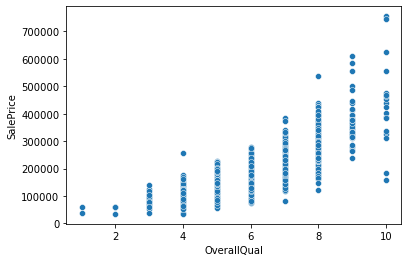

In [28]:
sns.scatterplot(x='OverallQual', y='SalePrice', data=df)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

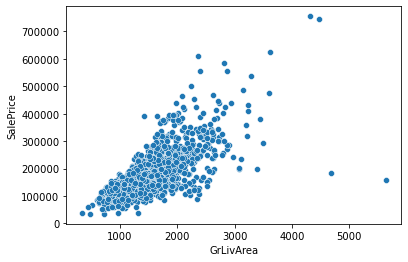

In [29]:

sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

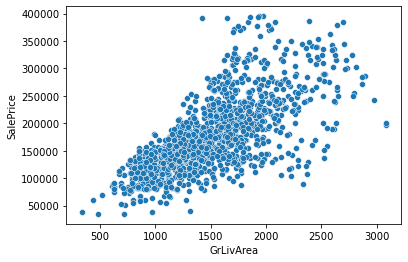

In [30]:

df = remove_outliers(df, ['GrLivArea', 'SalePrice'])
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)

In [31]:
df.shape

(1424, 48)

In [32]:


def get_metrics(y_train, y_train_pred, y_test, y_test_pred):
    training_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    training_r2 = metrics.r2_score(y_train, y_train_pred)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    test_r2 = metrics.r2_score(y_test, y_test_pred)
    training_rss = np.sum(np.square(y_train - y_train_pred))
    test_rss = np.sum(np.square(y_test - y_test_pred))

    d = {"r2": [training_r2, test_r2], "rmse": [
        training_rmse, test_rmse], "rss": [training_rss, test_rss]}

    return pd.DataFrame(d, index=["training", "test"])

# build a model with only numerical variables
df_num = df.drop(columns=categorical_variables)
df_num = df_num.drop(columns=['Id'])
X = df_num.drop(columns=['SalePrice'])
y = df_num['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Create scaler object
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
# Scale the features
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

model = Lasso(alpha=0.1)


def train_model(X_train, y_train, X_test, y_test, model):

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return model, get_metrics(y_train, y_train_pred, y_test, y_test_pred)


model, metrics_df = train_model(
    X_train_scaled, y_train, X_test_scaled, y_test, model)

metrics_df

,r2,rmse,rss
training,0.813885,28173.946981,7.905962e+11
test,0.802772,29225.547278,3.655688e+11


In [33]:

df['SalePrice'].describe()

count      1424.000000
mean     174356.681180
std       65483.652112
min       34900.000000
25%      129000.000000
50%      160000.000000
75%      208350.000000
max      395192.000000
Name: SalePrice, dtype: float64

In [34]:


pd.Series(model.coef_, X_train.columns).sort_values(ascending=False)

1stFlrSF        128157.711345
LotArea          92241.970393
2ndFlrSF         90043.075821
TotalBsmtSF      71860.716186
GarageArea       58997.218112
YearBuilt        57476.432872
BsmtFinSF1       46239.365657
LotFrontage      43272.990087
YearRemodAdd     38095.166512
WoodDeckSF       25782.789165
MasVnrArea       24676.512468
OpenPorchSF      19689.534693
GrLivArea        15868.446263
BsmtUnfSF         7370.702815
GarageYrBlt     -10082.917266
dtype: float64

,categorical,f_statistic,p_value
5,ExterQual,443.334831,1.439551e-204
18,KitchenQual,407.806352,3.032213e-192
12,GarageCars,351.207486,1.121129e-211
27,OverallQual,349.026840,0.000000e+00
4,BsmtQual,316.148635,8.158548e-196


ExterQual


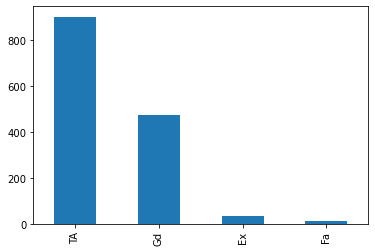

KitchenQual


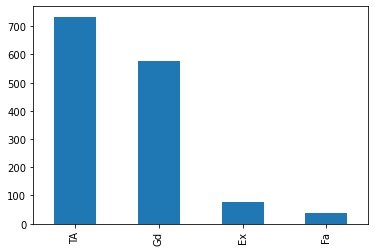

GarageCars


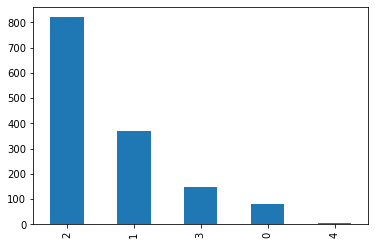

OverallQual


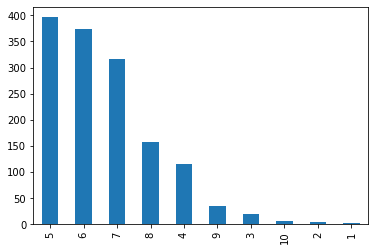

BsmtQual


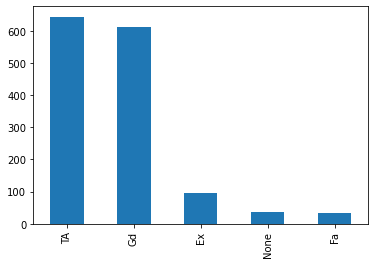

['ExterQual', 'KitchenQual', 'GarageCars', 'OverallQual', 'BsmtQual']


In [35]:

# sorted_by_f_st.head(2)
important_categoricals = sorted_by_f_st[sorted_by_f_st['f_statistic'] > 300]
display(important_categoricals)
important_categoricals = important_categoricals['categorical'].tolist()

for important_categorical in important_categoricals:
    print(important_categorical)
    # categorical_vs_target_barplot(df1, important_categorical, 'SalePrice')
    df[important_categorical].value_counts().plot(kind='bar')
    plt.show()


print(important_categoricals)

In [36]:

sorted_by_f_st


def sort_categorical_variables_by_independence(df, categorical_vars):
    independence_scores = []

    # Iterate through pairs of categorical variables
    for i in range(len(categorical_vars)):
        for j in range(i + 1, len(categorical_vars)):
            cross_tab = pd.crosstab(
                df[categorical_vars[i]], df[categorical_vars[j]])
            chi2, _, _, _ = chi2_contingency(cross_tab)
            n = cross_tab.sum().sum()
            cramers_v = np.sqrt(chi2 / (n * (min(cross_tab.shape) - 1)))
            independence_scores.append(
                (categorical_vars[i], categorical_vars[j], cramers_v))

    # Create DataFrame of independence scores and sort by Cramer's V
    sorted_df = pd.DataFrame(independence_scores, columns=[
                             'Variable 1', 'Variable 2', 'Cramer\'s V'])
    sorted_df = sorted_df.sort_values(by='Cramer\'s V', ascending=False)

    return sorted_df


sorted_df = sort_categorical_variables_by_independence(
    df, sorted_by_f_st['categorical'].tolist())

sorted_df

,Variable 1,Variable 2,Cramer's V
372,MSSubClass,HouseStyle,0.857268
397,Exterior1st,Exterior2nd,0.761482
158,GarageFinish,GarageType,0.686591
304,Neighborhood,MSZoning,0.650670
58,GarageCars,GarageFinish,0.633690
...,...,...,...
269,HeatingQC,LotConfig,0.051319
300,HalfBath,LotConfig,0.046981
234,MasVnrType,LotConfig,0.045716
266,HeatingQC,RoofStyle,0.042816


In [37]:

sorted_df[0:50]

,Variable 1,Variable 2,Cramer's V
372,MSSubClass,HouseStyle,0.857268
397,Exterior1st,Exterior2nd,0.761482
158,GarageFinish,GarageType,0.686591
304,Neighborhood,MSZoning,0.650670
58,GarageCars,GarageFinish,0.633690
2,ExterQual,OverallQual,0.596583
175,Fireplaces,FireplaceQu,0.585165
116,BsmtQual,BsmtFinType1,0.576856
292,HalfBath,MSSubClass,0.545207
64,GarageCars,GarageType,0.536703


In [38]:

len(categorical_variables)

31

In [39]:


def create_dummy_variables(df, categorical_variables):
    """
    Create dummy variables for categorical variables in a DataFrame.

    Parameters:
    df (pandas DataFrame): The DataFrame containing categorical variables.
    categorical_variables (list): List of categorical variables.

    Returns:
    pandas DataFrame: DataFrame with dummy variables for categorical variables.
    """
    dummies = []
    for categorical_variable in categorical_variables:
        dummy = pd.get_dummies(
            df[categorical_variable], prefix=categorical_variable, drop_first=True)
        dummies.append(dummy)

    df = df.drop(categorical_variables, axis=1)
    df = pd.concat([df] + dummies, axis=1)

    return df


def perform_rfe_and_get_summary(X_train, y_train, n_features=10):
    """
    Perform Recursive Feature Elimination (RFE) using Linear Regression and provide a summary.

    Parameters:
    X_train (pandas DataFrame or array-like): Training features.
    y_train (pandas Series or array-like): Training target.
    n_features (int): Number of features to select. Default is 10.

    Returns:
    tuple: Tuple containing RFE object and DataFrame summarizing the selection process.
    """
    lm = LinearRegression()
    rfe = RFE(lm, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)

    rfe_df = pd.DataFrame({
        "column": X_train.columns,
        "support": rfe.support_,
        "ranking": rfe.ranking_
    })
    rfe_df.sort_values(by="ranking", inplace=True)

    return rfe, rfe_df


def create_X_y(df, target_variable):
    """
    Create features (X) and target variable (y) from a DataFrame.

    Parameters:
    df (pandas DataFrame): The DataFrame containing features and target variable.
    target_variable (str): Name of the target variable.

    Returns:
    tuple: Tuple containing features (X) and target variable (y).
    """
    if 'Id' in df.columns:
        df = df.drop(columns=['Id'])

    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    return X, y


def perform_train_test_split(X, y, test_size=0.3, random_state=42):
    """
    Perform train-test split for features and target variable.

    Parameters:
    X (pandas DataFrame or array-like): Features.
    y (pandas Series or array-like): Target variable.
    test_size (float or int): Proportion of the dataset to include in the test split.
                              Default is 0.3 (30% for the test set).
    random_state (int): Controls the shuffling applied to the data before splitting.
                        Pass an int for reproducible output. Default is 42.

    Returns:
    tuple: Tuple containing X_train, X_test, y_train, y_test.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def scale_features_with_scaler(scaler, X_train, X_test):
    """
    Scale the features using a specified scaler.

    Parameters:
    scaler (scaler object): Scaler instance (e.g., StandardScaler, MinMaxScaler, etc.).
    X_train (pandas DataFrame or array-like): Training features.
    X_test (pandas DataFrame or array-like): Test features.

    Returns:
    tuple: Tuple containing scaled X_train and X_test.
    """
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


def scaled_arrays_to_dataframe(X_scaled, columns):
    """
    Convert scaled NumPy array to a pandas DataFrame with specified columns.

    Parameters:
    X_scaled (array-like): Scaled feature array.
    columns (list): Column names for the DataFrame.

    Returns:
    pandas DataFrame: DataFrame containing scaled features.
    """
    df_scaled = pd.DataFrame(X_scaled, columns=columns)
    return df_scaled

In [40]:


def experiment_num_features(n):
    df2 = create_dummy_variables(df, categorical_variables)

    X, y = create_X_y(df2, 'SalePrice')
    X_train, X_test, y_train, y_test = perform_train_test_split(
        X, y, test_size=0.3, random_state=42)
    X_train_scaled, X_test_scaled = scale_features_with_scaler(
        MinMaxScaler(), X_train, X_test)
    X_train_scaled = scaled_arrays_to_dataframe(
        X_train_scaled, X_train.columns)
    X_test_scaled = scaled_arrays_to_dataframe(X_test_scaled, X_test.columns)
    rfe, rfe_df = perform_rfe_and_get_summary(
        X_train_scaled, y_train, n_features=n)

    rfe_df1 = rfe_df[0:n]["column"].apply(
        lambda x: x.split("_")[0]).value_counts()

    return rfe, rfe_df, rfe_df1


num_features_to_rfe_info_mapping = {}
for i in range(50, 151, 10):
    rfe, rfe_df, rfe_df1 = experiment_num_features(i)
    num_features_to_rfe_info_mapping[i] = (rfe, rfe_df, rfe_df1)

In [41]:
num_features_to_rfe_info_mapping[50][2].index.tolist()

['TotRmsAbvGrd',
 'OverallQual',
 'OverallCond',
 'GarageCars',
 'MSZoning',
 'LotConfig',
 'GrLivArea',
 '2ndFlrSF',
 '1stFlrSF',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'YearBuilt',
 'LotArea',
 'BsmtFinType1',
 'LotFrontage',
 'Foundation',
 'BsmtFullBath',
 'Neighborhood',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'GarageFinish',
 'Exterior1st',
 'BsmtQual',
 'FireplaceQu']

In [42]:


def create_model_with_num_features(num_features):
    df1 = df[num_features_to_rfe_info_mapping[num_features]
             [2].index.tolist() + ['SalePrice']]
    print("actual number of independent features: ", len(df1.columns) - 1)
    cat = list(set(categorical_variables) & set(df1.columns))
    df2 = create_dummy_variables(df1, cat)

    X, y = create_X_y(df2, 'SalePrice')
    X_train, X_test, y_train, y_test = perform_train_test_split(
        X, y, test_size=0.3, random_state=42)
    X_train_scaled, X_test_scaled = scale_features_with_scaler(
        MinMaxScaler(), X_train, X_test)
    X_train_scaled = scaled_arrays_to_dataframe(
        X_train_scaled, X_train.columns)
    X_test_scaled = scaled_arrays_to_dataframe(X_test_scaled, X_test.columns)

    model = Lasso(alpha=0.1)
    model, metrics_df = train_model(
        X_train_scaled, y_train, X_test_scaled, y_test, model)
    print(num_features, len(df1.columns), df1.columns)
    display(metrics_df)
    return model, metrics_df, X_train_scaled


for num_features in num_features_to_rfe_info_mapping:
    model, metrics_df, X_train_scaled = create_model_with_num_features(
        num_features)

actual number of independent features:  25
50 26 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'MSZoning',
       'LotConfig', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF',
       'BsmtFinSF1', 'YearBuilt', 'LotArea', 'BsmtFinType1', 'LotFrontage',
       'Foundation', 'BsmtFullBath', 'Neighborhood', 'GarageType',
       'MSSubClass', 'Exterior2nd', 'GarageFinish', 'Exterior1st', 'BsmtQual',
       'FireplaceQu', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.931209,17128.646969,2.922170e+11
test,0.890978,21728.830941,2.020768e+11


actual number of independent features:  27
60 28 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'MSZoning',
       'Fireplaces', 'Exterior1st', 'LotFrontage', '1stFlrSF', 'BsmtFinType1',
       'LotConfig', 'YearBuilt', 'HeatingQC', 'BsmtFullBath', 'LotArea',
       'TotalBsmtSF', 'GarageType', '2ndFlrSF', 'GrLivArea', 'BsmtQual',
       'Neighborhood', 'FireplaceQu', 'Exterior2nd', 'Foundation',
       'MSSubClass', 'GarageFinish', 'BsmtFinSF1', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.931627,17076.497718,2.904403e+11
test,0.890804,21746.112823,2.023984e+11


actual number of independent features:  32
70 33 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'Fireplaces', 'Exterior1st', 'MSSubClass',
       'GrLivArea', 'MasVnrArea', 'YearBuilt', 'LotArea', 'LotFrontage',
       'BsmtExposure', 'BsmtQual', 'TotalBsmtSF', 'HeatingQC', 'BsmtFinType1',
       'BsmtFinSF1', 'OpenPorchSF', '1stFlrSF', '2ndFlrSF', 'LotConfig',
       'WoodDeckSF', 'FireplaceQu', 'Foundation', 'GarageType', 'GarageFinish',
       'Exterior2nd', 'BsmtFullBath', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.936972,16395.423093,2.677347e+11
test,0.892060,21620.697710,2.000706e+11


actual number of independent features:  35
80 36 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'Neighborhood',
       'GarageCars', 'MSZoning', 'MSSubClass', 'KitchenQual', 'Fireplaces',
       'MasVnrType', 'Exterior1st', 'RoofStyle', 'GarageType', 'TotalBsmtSF',
       'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'BsmtQual', 'BsmtExposure',
       'LotArea', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF',
       'GarageFinish', '2ndFlrSF', 'GrLivArea', 'LotConfig', 'WoodDeckSF',
       'OpenPorchSF', 'Exterior2nd', 'FireplaceQu', 'HalfBath', 'Foundation',
       'LotFrontage', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.939806,16022.688823,2.556997e+11
test,0.887573,22065.487729,2.083871e+11


actual number of independent features:  36
90 37 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'FireplaceQu',
       'Neighborhood', 'MSSubClass', 'GarageCars', 'BsmtQual', 'MSZoning',
       'KitchenQual', 'MasVnrType', 'Fireplaces', 'Exterior1st', 'RoofStyle',
       'MasVnrArea', 'BsmtFinSF1', 'YearBuilt', 'LotArea', 'LotFrontage',
       'BsmtExposure', '1stFlrSF', 'BsmtFullBath', 'HeatingQC', 'TotalBsmtSF',
       'OpenPorchSF', '2ndFlrSF', 'GrLivArea', 'LotConfig', 'GarageArea',
       'WoodDeckSF', 'GarageFinish', 'Foundation', 'HalfBath', 'Exterior2nd',
       'GarageType', 'BsmtFinType1', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.939971,16000.608845,2.549954e+11
test,0.888460,21978.246282,2.067425e+11


actual number of independent features:  39
100 40 Index(['TotRmsAbvGrd', 'Neighborhood', 'OverallQual', 'OverallCond',
       'MSSubClass', 'FireplaceQu', 'BsmtQual', 'MSZoning', 'GarageCars',
       'KitchenQual', 'MasVnrType', 'Fireplaces', 'Exterior1st', 'Exterior2nd',
       'RoofStyle', 'BsmtFinSF1', 'MasVnrArea', 'YearRemodAdd', 'BsmtUnfSF',
       'LotFrontage', 'YearBuilt', 'LotArea', '1stFlrSF', 'BsmtFinType1',
       'TotalBsmtSF', 'BsmtExposure', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'GarageFinish', 'GarageType', 'HalfBath',
       'HeatingQC', 'HouseStyle', 'LotConfig', 'Foundation', 'BsmtFullBath',
       'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.940621,15913.790228,2.522357e+11
test,0.890712,21755.255336,2.025686e+11


actual number of independent features:  42
110 43 Index(['Neighborhood', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond',
       'MSSubClass', 'FireplaceQu', 'BsmtQual', 'MSZoning', 'GarageCars',
       'Fireplaces', 'MasVnrType', 'Exterior2nd', 'KitchenQual', 'LotConfig',
       'Exterior1st', 'GarageType', 'BsmtFullBath', 'BsmtFinType1',
       'RoofStyle', 'GarageArea', 'LotArea', 'TotalBsmtSF', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'LotFrontage',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'WoodDeckSF',
       'OpenPorchSF', 'GarageFinish', 'HalfBath', 'HeatingQC', 'LotShape',
       'HouseStyle', 'Foundation', 'MoSold', 'BsmtExposure', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.942040,15722.519087,2.462088e+11
test,0.887652,22057.746240,2.082409e+11


actual number of independent features:  42
120 43 Index(['Neighborhood', 'TotRmsAbvGrd', 'MSSubClass', 'OverallQual',
       'OverallCond', 'FireplaceQu', 'HouseStyle', 'Exterior2nd', 'BsmtQual',
       'Exterior1st', 'GarageCars', 'MSZoning', 'Fireplaces', 'LotConfig',
       'MasVnrType', 'KitchenQual', 'GarageType', 'BsmtFullBath', 'RoofStyle',
       'BsmtFinType1', '2ndFlrSF', '1stFlrSF', 'LotFrontage', 'GrLivArea',
       'BsmtUnfSF', 'OpenPorchSF', 'LotArea', 'GarageArea', 'TotalBsmtSF',
       'YearBuilt', 'BsmtFinSF1', 'MasVnrArea', 'GarageYrBlt', 'YearRemodAdd',
       'BsmtExposure', 'Foundation', 'HeatingQC', 'HalfBath', 'GarageFinish',
       'LotShape', 'MoSold', 'WoodDeckSF', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.942040,15722.531294,2.462092e+11
test,0.887648,22058.118299,2.082479e+11


actual number of independent features:  43
130 44 Index(['Neighborhood', 'TotRmsAbvGrd', 'MSSubClass', 'OverallQual',
       'OverallCond', 'Exterior2nd', 'Exterior1st', 'FireplaceQu',
       'HouseStyle', 'GarageCars', 'BsmtQual', 'MSZoning', 'LotConfig',
       'BsmtFinType1', 'KitchenQual', 'MoSold', 'MasVnrType', 'Fireplaces',
       'BsmtFullBath', 'RoofStyle', 'GarageType', 'FullBath', 'BsmtUnfSF',
       'GarageFinish', '1stFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'GarageArea',
       'GarageYrBlt', 'GrLivArea', '2ndFlrSF', 'TotalBsmtSF', 'BsmtFinSF1',
       'Foundation', 'MasVnrArea', 'YearRemodAdd', 'YearBuilt', 'LotArea',
       'BsmtExposure', 'HalfBath', 'HeatingQC', 'LotShape', 'LotFrontage',
       'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.942335,15682.426534,2.449547e+11
test,0.885681,22250.432236,2.118950e+11


actual number of independent features:  44
140 45 Index(['Neighborhood', 'MSSubClass', 'TotRmsAbvGrd', 'OverallQual',
       'Exterior2nd', 'OverallCond', 'Exterior1st', 'RoofStyle', 'HouseStyle',
       'FireplaceQu', 'GarageCars', 'BsmtQual', 'MSZoning', 'BsmtExposure',
       'Fireplaces', 'KitchenQual', 'LotConfig', 'MoSold', 'MasVnrType',
       'BsmtFinType1', 'BsmtFullBath', 'GarageType', 'Foundation',
       'MasVnrArea', 'LotArea', 'LotFrontage', 'BsmtFinSF1', 'BsmtUnfSF',
       'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd', 'GarageYrBlt',
       '2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'GarageArea', 'GrLivArea',
       'LotShape', 'YrSold', 'HeatingQC', 'HalfBath', 'GarageFinish',
       'FullBath', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.942841,15613.468556,2.428053e+11
test,0.886684,22152.597002,2.100357e+11


actual number of independent features:  45
150 46 Index(['Neighborhood', 'MSSubClass', 'TotRmsAbvGrd', 'Exterior2nd',
       'OverallQual', 'OverallCond', 'Exterior1st', 'HouseStyle',
       'FireplaceQu', 'RoofStyle', 'BsmtExposure', 'MoSold', 'BsmtQual',
       'MSZoning', 'GarageCars', 'KitchenQual', 'LotConfig', 'BsmtFinType1',
       'MasVnrType', 'Fireplaces', 'BedroomAbvGr', 'BsmtFullBath',
       'Foundation', 'YrSold', 'GarageType', 'YearBuilt', 'YearRemodAdd',
       'WoodDeckSF', 'BsmtFinSF1', 'GarageArea', 'LotArea', 'FullBath',
       'LotFrontage', 'BsmtUnfSF', 'GarageYrBlt', 'GrLivArea', '2ndFlrSF',
       '1stFlrSF', 'OpenPorchSF', 'TotalBsmtSF', 'GarageFinish', 'LotShape',
       'HeatingQC', 'HalfBath', 'MasVnrArea', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.943149,15571.381990,2.414981e+11
test,0.884966,22319.888802,2.132199e+11


In [43]:


def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for features in a DataFrame.

    Parameters:
    X (pandas DataFrame): DataFrame containing the features.

    Returns:
    pandas DataFrame: DataFrame with calculated VIF for each feature.
    """
    vif_df = pd.DataFrame()
    vif_df['Features'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(
        X.values, i) for i in range(X.shape[1])]
    vif_df['VIF'] = round(vif_df['VIF'], 2)
    vif_df = vif_df.sort_values(by="VIF", ascending=False)
    return vif_df


def build_ols_model(X, y):
    """
    Build an Ordinary Least Squares (OLS) model using statsmodels, print the model summary, and return the fitted model.

    Parameters:
    X (pandas DataFrame): DataFrame containing the features.
    y (pandas Series): Series containing the target variable.

    Returns:
    statsmodels regression summary: Summary of the fitted OLS model.
    """
    X = sm.add_constant(X)  # Adding a constant column for intercept
    results = sm.OLS(y.values, X).fit()  # Fit the OLS model
    print(results.summary())  # Print the summary of the fitted model
    return results  # Return the fitted model


def build_ols_lasso_model(X, y):
    """
    Build an Ordinary Least Squares (OLS) model using statsmodels, print the model summary, and return the fitted model.

    Parameters:
    X (pandas DataFrame): DataFrame containing the features.
    y (pandas Series): Series containing the target variable.

    Returns:
    statsmodels regression summary: Summary of the fitted OLS model.
    """
    X = sm.add_constant(X)  # Adding a constant column for intercept
    results = sm.OLS(y.values, X).fit_regularized(
        method='sqrt_lasso')  # Fit the OLS model
    try:
        print(results.summary())  # Print the summary of the fitted model
    except Exception as e:
        print(e)
    return results  # Return the fitted model


def drop_features_and_create_model(df, features_to_drop, target_variable, model_builder=build_ols_model):
    df1 = df[num_features_to_rfe_info_mapping[num_features]
             [2].index.tolist() + [target_variable]]

    df1 = df1.drop(columns=features_to_drop)
    print("actual number of independent features: ", len(df1.columns) - 1)
    cat = list(set(categorical_variables) & set(df1.columns))
    df2 = create_dummy_variables(df1, cat)

    X, y = create_X_y(df2, 'SalePrice')
    X_train, X_test, y_train, y_test = perform_train_test_split(
        X, y, test_size=0.3, random_state=42)
    X_train_scaled, X_test_scaled = scale_features_with_scaler(
        MinMaxScaler(), X_train, X_test)
    X_train_scaled = scaled_arrays_to_dataframe(
        X_train_scaled, X_train.columns)
    X_test_scaled = scaled_arrays_to_dataframe(X_test_scaled, X_test.columns)

    vif_df = calculate_vif(X_train_scaled)

    display(vif_df)
    variables_with_infinite_vif = vif_df[vif_df['VIF'] == np.inf]["Features"].apply(
        lambda x: x.split("_")[0]).value_counts().index.tolist()

    print("variables with infinite VIF: ", variables_with_infinite_vif)
    return model_builder(X_train_scaled, y_train), (X_train_scaled, X_test_scaled, y_train, y_test)


def get_summary_info_sorted(model):
    """
    Extract feature names, coefficients, t-values, and p-values from the summary of an OLS model and sort by p-values.

    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): Fitted OLS model.

    Returns:
    pandas.DataFrame: DataFrame containing information for each feature sorted by p-values.
    """
    # Get the summary of the fitted model
    summary = model.summary()

    # Extract information from the summary
    results = summary.tables[1].data

    # Create DataFrame with extracted information
    columns = ["feature", "coef", "std err", "t", "p", "[0.025", "0.975]"]
    df = pd.DataFrame(results)

    # display(df)

    new_header = df.iloc[0]  # Grab the first row for the header
    new_header[0] = "feature"
    df = df[1:]  # Take the data except the first row
    df.columns = new_header  # Set the header row as the DataFrame column names
    # print("columns are", df.columns)
    # Convert relevant columns to numeric types
    p_column = 'P>|t|'
    df[['coef', 't', p_column]] = df[[
        'coef', 't', p_column]].apply(pd.to_numeric)

    # # Sort DataFrame by p-values
    sorted_df = df.sort_values(by=p_column, ascending=False)

    return sorted_df


def get_r2_adjusted_r2(model):
    """
    Extract R-squared and adjusted R-squared values from the summary of a fitted model.

    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): Fitted regression model.

    Returns:
    tuple: Tuple containing R-squared and adjusted R-squared values.
    """
    # Get the summary of the fitted model
    summary = model.summary()

    # Extract R-squared and adjusted R-squared from the summary
    r_squared = float(summary.tables[0].data[0][3])
    adj_r_squared = float(summary.tables[0].data[1][3])

    print("R-squared: ", r_squared, "Adjusted R-squared: ", adj_r_squared)
    return r_squared, adj_r_squared

In [44]:
for num_features in num_features_to_rfe_info_mapping:
    model, metrics_df, X_train_scaled = create_model_with_num_features(
        num_features)

num_features = 50
model, metrics_df, X_train_scaled = create_model_with_num_features(
    num_features)

actual number of independent features:  25
50 26 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'MSZoning',
       'LotConfig', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF',
       'BsmtFinSF1', 'YearBuilt', 'LotArea', 'BsmtFinType1', 'LotFrontage',
       'Foundation', 'BsmtFullBath', 'Neighborhood', 'GarageType',
       'MSSubClass', 'Exterior2nd', 'GarageFinish', 'Exterior1st', 'BsmtQual',
       'FireplaceQu', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.931209,17128.646969,2.922170e+11
test,0.890978,21728.830941,2.020768e+11


actual number of independent features:  27
60 28 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'MSZoning',
       'Fireplaces', 'Exterior1st', 'LotFrontage', '1stFlrSF', 'BsmtFinType1',
       'LotConfig', 'YearBuilt', 'HeatingQC', 'BsmtFullBath', 'LotArea',
       'TotalBsmtSF', 'GarageType', '2ndFlrSF', 'GrLivArea', 'BsmtQual',
       'Neighborhood', 'FireplaceQu', 'Exterior2nd', 'Foundation',
       'MSSubClass', 'GarageFinish', 'BsmtFinSF1', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.931627,17076.497718,2.904403e+11
test,0.890804,21746.112823,2.023984e+11


actual number of independent features:  32
70 33 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'Fireplaces', 'Exterior1st', 'MSSubClass',
       'GrLivArea', 'MasVnrArea', 'YearBuilt', 'LotArea', 'LotFrontage',
       'BsmtExposure', 'BsmtQual', 'TotalBsmtSF', 'HeatingQC', 'BsmtFinType1',
       'BsmtFinSF1', 'OpenPorchSF', '1stFlrSF', '2ndFlrSF', 'LotConfig',
       'WoodDeckSF', 'FireplaceQu', 'Foundation', 'GarageType', 'GarageFinish',
       'Exterior2nd', 'BsmtFullBath', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.936972,16395.423093,2.677347e+11
test,0.892060,21620.697710,2.000706e+11


actual number of independent features:  35
80 36 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'Neighborhood',
       'GarageCars', 'MSZoning', 'MSSubClass', 'KitchenQual', 'Fireplaces',
       'MasVnrType', 'Exterior1st', 'RoofStyle', 'GarageType', 'TotalBsmtSF',
       'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'BsmtQual', 'BsmtExposure',
       'LotArea', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF',
       'GarageFinish', '2ndFlrSF', 'GrLivArea', 'LotConfig', 'WoodDeckSF',
       'OpenPorchSF', 'Exterior2nd', 'FireplaceQu', 'HalfBath', 'Foundation',
       'LotFrontage', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.939806,16022.688823,2.556997e+11
test,0.887573,22065.487729,2.083871e+11


actual number of independent features:  36
90 37 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'FireplaceQu',
       'Neighborhood', 'MSSubClass', 'GarageCars', 'BsmtQual', 'MSZoning',
       'KitchenQual', 'MasVnrType', 'Fireplaces', 'Exterior1st', 'RoofStyle',
       'MasVnrArea', 'BsmtFinSF1', 'YearBuilt', 'LotArea', 'LotFrontage',
       'BsmtExposure', '1stFlrSF', 'BsmtFullBath', 'HeatingQC', 'TotalBsmtSF',
       'OpenPorchSF', '2ndFlrSF', 'GrLivArea', 'LotConfig', 'GarageArea',
       'WoodDeckSF', 'GarageFinish', 'Foundation', 'HalfBath', 'Exterior2nd',
       'GarageType', 'BsmtFinType1', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.939971,16000.608845,2.549954e+11
test,0.888460,21978.246282,2.067425e+11


actual number of independent features:  39
100 40 Index(['TotRmsAbvGrd', 'Neighborhood', 'OverallQual', 'OverallCond',
       'MSSubClass', 'FireplaceQu', 'BsmtQual', 'MSZoning', 'GarageCars',
       'KitchenQual', 'MasVnrType', 'Fireplaces', 'Exterior1st', 'Exterior2nd',
       'RoofStyle', 'BsmtFinSF1', 'MasVnrArea', 'YearRemodAdd', 'BsmtUnfSF',
       'LotFrontage', 'YearBuilt', 'LotArea', '1stFlrSF', 'BsmtFinType1',
       'TotalBsmtSF', 'BsmtExposure', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'GarageFinish', 'GarageType', 'HalfBath',
       'HeatingQC', 'HouseStyle', 'LotConfig', 'Foundation', 'BsmtFullBath',
       'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.940621,15913.790228,2.522357e+11
test,0.890712,21755.255336,2.025686e+11


actual number of independent features:  42
110 43 Index(['Neighborhood', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond',
       'MSSubClass', 'FireplaceQu', 'BsmtQual', 'MSZoning', 'GarageCars',
       'Fireplaces', 'MasVnrType', 'Exterior2nd', 'KitchenQual', 'LotConfig',
       'Exterior1st', 'GarageType', 'BsmtFullBath', 'BsmtFinType1',
       'RoofStyle', 'GarageArea', 'LotArea', 'TotalBsmtSF', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'LotFrontage',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'WoodDeckSF',
       'OpenPorchSF', 'GarageFinish', 'HalfBath', 'HeatingQC', 'LotShape',
       'HouseStyle', 'Foundation', 'MoSold', 'BsmtExposure', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.942040,15722.519087,2.462088e+11
test,0.887652,22057.746240,2.082409e+11


actual number of independent features:  42
120 43 Index(['Neighborhood', 'TotRmsAbvGrd', 'MSSubClass', 'OverallQual',
       'OverallCond', 'FireplaceQu', 'HouseStyle', 'Exterior2nd', 'BsmtQual',
       'Exterior1st', 'GarageCars', 'MSZoning', 'Fireplaces', 'LotConfig',
       'MasVnrType', 'KitchenQual', 'GarageType', 'BsmtFullBath', 'RoofStyle',
       'BsmtFinType1', '2ndFlrSF', '1stFlrSF', 'LotFrontage', 'GrLivArea',
       'BsmtUnfSF', 'OpenPorchSF', 'LotArea', 'GarageArea', 'TotalBsmtSF',
       'YearBuilt', 'BsmtFinSF1', 'MasVnrArea', 'GarageYrBlt', 'YearRemodAdd',
       'BsmtExposure', 'Foundation', 'HeatingQC', 'HalfBath', 'GarageFinish',
       'LotShape', 'MoSold', 'WoodDeckSF', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.942040,15722.531294,2.462092e+11
test,0.887648,22058.118299,2.082479e+11


actual number of independent features:  43
130 44 Index(['Neighborhood', 'TotRmsAbvGrd', 'MSSubClass', 'OverallQual',
       'OverallCond', 'Exterior2nd', 'Exterior1st', 'FireplaceQu',
       'HouseStyle', 'GarageCars', 'BsmtQual', 'MSZoning', 'LotConfig',
       'BsmtFinType1', 'KitchenQual', 'MoSold', 'MasVnrType', 'Fireplaces',
       'BsmtFullBath', 'RoofStyle', 'GarageType', 'FullBath', 'BsmtUnfSF',
       'GarageFinish', '1stFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'GarageArea',
       'GarageYrBlt', 'GrLivArea', '2ndFlrSF', 'TotalBsmtSF', 'BsmtFinSF1',
       'Foundation', 'MasVnrArea', 'YearRemodAdd', 'YearBuilt', 'LotArea',
       'BsmtExposure', 'HalfBath', 'HeatingQC', 'LotShape', 'LotFrontage',
       'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.942335,15682.426534,2.449547e+11
test,0.885681,22250.432236,2.118950e+11


actual number of independent features:  44
140 45 Index(['Neighborhood', 'MSSubClass', 'TotRmsAbvGrd', 'OverallQual',
       'Exterior2nd', 'OverallCond', 'Exterior1st', 'RoofStyle', 'HouseStyle',
       'FireplaceQu', 'GarageCars', 'BsmtQual', 'MSZoning', 'BsmtExposure',
       'Fireplaces', 'KitchenQual', 'LotConfig', 'MoSold', 'MasVnrType',
       'BsmtFinType1', 'BsmtFullBath', 'GarageType', 'Foundation',
       'MasVnrArea', 'LotArea', 'LotFrontage', 'BsmtFinSF1', 'BsmtUnfSF',
       'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd', 'GarageYrBlt',
       '2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'GarageArea', 'GrLivArea',
       'LotShape', 'YrSold', 'HeatingQC', 'HalfBath', 'GarageFinish',
       'FullBath', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.942841,15613.468556,2.428053e+11
test,0.886684,22152.597002,2.100357e+11


actual number of independent features:  45
150 46 Index(['Neighborhood', 'MSSubClass', 'TotRmsAbvGrd', 'Exterior2nd',
       'OverallQual', 'OverallCond', 'Exterior1st', 'HouseStyle',
       'FireplaceQu', 'RoofStyle', 'BsmtExposure', 'MoSold', 'BsmtQual',
       'MSZoning', 'GarageCars', 'KitchenQual', 'LotConfig', 'BsmtFinType1',
       'MasVnrType', 'Fireplaces', 'BedroomAbvGr', 'BsmtFullBath',
       'Foundation', 'YrSold', 'GarageType', 'YearBuilt', 'YearRemodAdd',
       'WoodDeckSF', 'BsmtFinSF1', 'GarageArea', 'LotArea', 'FullBath',
       'LotFrontage', 'BsmtUnfSF', 'GarageYrBlt', 'GrLivArea', '2ndFlrSF',
       '1stFlrSF', 'OpenPorchSF', 'TotalBsmtSF', 'GarageFinish', 'LotShape',
       'HeatingQC', 'HalfBath', 'MasVnrArea', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.943149,15571.381990,2.414981e+11
test,0.884966,22319.888802,2.132199e+11


actual number of independent features:  25
50 26 Index(['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'MSZoning',
       'LotConfig', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF',
       'BsmtFinSF1', 'YearBuilt', 'LotArea', 'BsmtFinType1', 'LotFrontage',
       'Foundation', 'BsmtFullBath', 'Neighborhood', 'GarageType',
       'MSSubClass', 'Exterior2nd', 'GarageFinish', 'Exterior1st', 'BsmtQual',
       'FireplaceQu', 'SalePrice'],
      dtype='object')


,r2,rmse,rss
training,0.931209,17128.646969,2.922170e+11
test,0.890978,21728.830941,2.020768e+11


In [45]:
vif_df = calculate_vif(X_train_scaled)

variables_with_infinite_vif = vif_df[vif_df['VIF'] == np.inf]["Features"].apply(
    lambda x: x.split("_")[0]).value_counts().index.tolist()

print("variables with infinite VIF: ", variables_with_infinite_vif)


build_ols_model(X_train_scaled, y_train)

variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'Exterior2nd', 'BsmtQual', 'GarageFinish', 'BsmtFinType1', 'Exterior1st', 'GarageType']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     82.67
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:44:16   Log-Likelihood:                -11123.
No. Observations:                 996   AIC:                         2.253e+04
Df Residuals:                     855   BIC:                         2.322e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                           coef

In [46]:
sorted_df[sorted_df['Variable 2'] == 'BedroomAbvGr'].head(1)

##

,Variable 1,Variable 2,Cramer's V
151,FullBath,BedroomAbvGr,0.445667


In [47]:
columns_to_drop = []

In [48]:
#


model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)

df3[['feature', 'P>|t|']].head(20)

actual number of independent features:  25


,Features,VIF
145,TotRmsAbvGrd_12,inf
87,OverallQual_9,inf
85,OverallQual_7,inf
84,OverallQual_6,inf
23,Exterior2nd_CBlock,inf
...,...,...
96,Foundation_Stone,1.26
70,MSSubClass_85,1.17
63,MSSubClass_40,1.16
56,BsmtFullBath_3,1.13


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'Exterior2nd', 'BsmtQual', 'GarageFinish', 'BsmtFinType1', 'Exterior1st', 'GarageType']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     82.67
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:44:35   Log-Likelihood:                -11123.
No. Observations:                 996   AIC:                         2.253e+04
Df Residuals:                     855   BIC:                         2.322e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                           coef

R-squared:  0.931 Adjusted R-squared:  0.92


,feature,P>|t|
47,LotConfig_Inside,0.991
110,Exterior1st_Stucco,0.986
12,GarageType_BuiltIn,0.978
109,Exterior1st_Stone,0.977
133,Neighborhood_SawyerW,0.968
130,Neighborhood_OldTown,0.956
52,OverallCond_6,0.946
104,Exterior1st_CemntBd,0.937
65,MSSubClass_40,0.936
72,MSSubClass_85,0.929


In [49]:
columns_to_drop.extend(['LotConfig'])
print("Dropped columns: ", columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped columns:  ['LotConfig']
actual number of independent features:  24


,Features,VIF
141,TotRmsAbvGrd_12,inf
83,OverallQual_9,inf
81,OverallQual_7,inf
80,OverallQual_6,inf
23,Exterior2nd_CBlock,inf
...,...,...
93,Foundation_Wood,1.28
92,Foundation_Stone,1.26
66,MSSubClass_85,1.16
59,MSSubClass_40,1.16


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'Exterior2nd', 'BsmtQual', 'GarageFinish', 'BsmtFinType1', 'Exterior1st', 'GarageType']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     83.43
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:44:58   Log-Likelihood:                -11134.
No. Observations:                 996   AIC:                         2.254e+04
Df Residuals:                     859   BIC:                         2.321e+04
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
                           coef

,feature,P>|t|
48,OverallCond_6,0.999
10,GarageType_Attchd,0.992
64,MSSubClass_60,0.988
100,Exterior1st_CemntBd,0.982
106,Exterior1st_Stucco,0.968
61,MSSubClass_40,0.955
129,Neighborhood_SawyerW,0.948
65,MSSubClass_70,0.945
21,BsmtFinType1_Unf,0.934
44,OverallCond_2,0.932


In [50]:
columns_to_drop.extend(['GarageType'])
print("Dropped columns: ", columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped columns:  ['LotConfig', 'GarageType']
actual number of independent features:  23


,Features,VIF
68,BsmtQual_None,inf
36,OverallCond_2,inf
38,OverallCond_4,inf
39,OverallCond_5,inf
40,OverallCond_6,inf
...,...,...
86,Foundation_Stone,1.25
87,Foundation_Wood,1.22
60,MSSubClass_85,1.16
53,MSSubClass_40,1.15


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'BsmtQual', 'Exterior1st', 'Exterior2nd', 'GarageFinish', 'BsmtFinType1']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     86.66
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:45:18   Log-Likelihood:                -11137.
No. Observations:                 996   AIC:                         2.254e+04
Df Residuals:                     864   BIC:                         2.318e+04
Df Model:                         131                                         
Covariance Type:            nonrobust                                         
                           coef    std err   

,feature,P>|t|
55,MSSubClass_40,0.989
97,Exterior1st_MetalSd,0.982
38,OverallCond_2,0.955
15,BsmtFinType1_Unf,0.947
123,Neighborhood_SawyerW,0.935
94,Exterior1st_CemntBd,0.867
111,Neighborhood_Gilbert,0.863
58,MSSubClass_60,0.857
110,Neighborhood_Edwards,0.844
72,OverallQual_2,0.842


In [51]:
columns_to_drop.extend(['MSSubClass'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig', 'GarageType', 'MSSubClass']

actual number of independent features:  22


,Features,VIF
61,OverallQual_7,inf
36,OverallCond_2,inf
38,OverallCond_4,inf
39,OverallCond_5,inf
40,OverallCond_6,inf
...,...,...
10,BsmtFinType1_LwQ,1.49
72,Foundation_Stone,1.23
88,Neighborhood_Blueste,1.19
73,Foundation_Wood,1.15


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'BsmtQual', 'Exterior1st', 'BsmtFinType1', 'GarageFinish', 'Exterior2nd']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     93.21
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:45:31   Log-Likelihood:                -11163.
No. Observations:                 996   AIC:                         2.256e+04
Df Residuals:                     878   BIC:                         2.314e+04
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
                           coef    std err   

,feature,P>|t|
58,OverallQual_2,0.986
23,Exterior2nd_MetalSd,0.932
15,BsmtFinType1_Unf,0.924
81,Exterior1st_HdBoard,0.923
51,FireplaceQu_None,0.908
90,Neighborhood_Blueste,0.904
80,Exterior1st_CemntBd,0.902
17,Exterior2nd_Brk Cmn,0.898
84,Exterior1st_Plywood,0.895
38,OverallCond_2,0.893


In [52]:

columns_to_drop.extend(['Exterior2nd'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig', 'GarageType', 'MSSubClass', 'Exterior2nd']

actual number of independent features:  21


,Features,VIF
53,GarageCars_4,inf
26,OverallCond_7,inf
28,OverallCond_9,inf
39,BsmtQual_None,inf
41,OverallQual_2,inf
...,...,...
57,Foundation_Stone,1.22
62,Exterior1st_CBlock,1.19
73,Neighborhood_Blueste,1.19
58,Foundation_Wood,1.14


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'BsmtQual', 'BsmtFinType1', 'GarageFinish']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     106.6
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:45:39   Log-Likelihood:                -11167.
No. Observations:                 996   AIC:                         2.254e+04
Df Residuals:                     892   BIC:                         2.305e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.02

,feature,P>|t|
27,OverallCond_6,0.967
56,Foundation_CBlock,0.947
43,OverallQual_2,0.927
66,Exterior1st_HdBoard,0.914
75,Neighborhood_Blueste,0.908
85,Neighborhood_Mitchel,0.899
23,OverallCond_2,0.892
74,Exterior1st_WdShing,0.883
36,FireplaceQu_None,0.862
15,BsmtFinType1_Unf,0.831


In [53]:

columns_to_drop.extend(['Foundation'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig', 'GarageType', 'MSSubClass', 'Exterior2nd', 'Foundation']

actual number of independent features:  20


,Features,VIF
51,GarageCars_2,inf
26,OverallCond_7,inf
28,OverallCond_9,inf
39,BsmtQual_None,inf
41,OverallQual_2,inf
...,...,...
60,Exterior1st_ImStucc,1.22
54,Exterior1st_AsphShn,1.19
57,Exterior1st_CBlock,1.18
68,Neighborhood_Blueste,1.18


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'BsmtQual', 'BsmtFinType1', 'GarageFinish']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     111.0
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:45:47   Log-Likelihood:                -11174.
No. Observations:                 996   AIC:                         2.255e+04
Df Residuals:                     897   BIC:                         2.303e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.02

,feature,P>|t|
27,OverallCond_6,0.989
70,Neighborhood_Blueste,0.977
36,FireplaceQu_None,0.929
61,Exterior1st_HdBoard,0.926
69,Exterior1st_WdShing,0.901
43,OverallQual_2,0.892
23,OverallCond_2,0.881
1,const,0.851
15,BsmtFinType1_Unf,0.849
102,TotRmsAbvGrd_11,0.848


In [54]:
columns_to_drop.extend(['FireplaceQu'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu']

actual number of independent features:  19


,Features,VIF
48,GarageCars_4,inf
26,OverallCond_7,inf
28,OverallCond_9,inf
32,OverallQual_2,inf
33,OverallQual_3,inf
...,...,...
49,Exterior1st_AsphShn,1.19
52,Exterior1st_CBlock,1.18
55,Exterior1st_ImStucc,1.17
63,Neighborhood_Blueste,1.17


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'BsmtQual', 'BsmtFinType1', 'GarageFinish']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     114.8
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:45:53   Log-Likelihood:                -11185.
No. Observations:                 996   AIC:                         2.256e+04
Df Residuals:                     902   BIC:                         2.302e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.02

,feature,P>|t|
23,OverallCond_2,0.998
1,const,0.956
65,Neighborhood_Blueste,0.956
76,Neighborhood_NAmes,0.947
83,Neighborhood_Sawyer,0.934
77,Neighborhood_NPkVill,0.909
56,Exterior1st_HdBoard,0.902
71,Neighborhood_Edwards,0.863
34,OverallQual_2,0.860
66,Neighborhood_BrDale,0.827


In [55]:
columns_to_drop.extend(['Neighborhood'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood']

actual number of independent features:  18


,Features,VIF
36,OverallQual_6,inf
26,OverallCond_7,inf
28,OverallCond_9,inf
32,OverallQual_2,inf
33,OverallQual_3,inf
...,...,...
58,Exterior1st_Stone,1.30
49,Exterior1st_AsphShn,1.17
52,Exterior1st_CBlock,1.14
55,Exterior1st_ImStucc,1.13


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'BsmtQual', 'BsmtFinType1', 'GarageFinish']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     135.0
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:45:56   Log-Likelihood:                -11259.
No. Observations:                 996   AIC:                         2.266e+04
Df Residuals:                     926   BIC:                         2.300e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025

,feature,P>|t|
59,Exterior1st_Plywood,0.975
32,BsmtFullBath_2,0.969
47,GarageCars_1,0.964
71,TotRmsAbvGrd_9,0.924
72,TotRmsAbvGrd_10,0.919
70,TotRmsAbvGrd_8,0.914
64,Exterior1st_WdShing,0.814
58,Exterior1st_MetalSd,0.806
34,OverallQual_2,0.777
56,Exterior1st_HdBoard,0.754


In [56]:

columns_to_drop.extend(['Exterior1st'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st']

actual number of independent features:  17


,Features,VIF
58,TotRmsAbvGrd_12,inf
25,OverallCond_6,inf
39,OverallQual_9,inf
38,OverallQual_8,inf
21,OverallCond_2,inf
22,OverallCond_3,inf
23,OverallCond_4,inf
24,OverallCond_5,inf
26,OverallCond_7,inf
34,OverallQual_4,inf


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'GarageFinish', 'BsmtQual', 'BsmtFinType1']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     164.2
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:45:57   Log-Likelihood:                -11280.
No. Observations:                 996   AIC:                         2.267e+04
Df Residuals:                     940   BIC:                         2.295e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025  

,feature,P>|t|
56,TotRmsAbvGrd_8,0.996
57,TotRmsAbvGrd_9,0.940
32,BsmtFullBath_2,0.922
58,TotRmsAbvGrd_10,0.900
43,GarageCars_1,0.785
55,TotRmsAbvGrd_7,0.697
34,OverallQual_2,0.618
39,OverallQual_7,0.612
12,BsmtFinType1_LwQ,0.606
54,TotRmsAbvGrd_6,0.569


In [57]:

columns_to_drop.extend(['TotRmsAbvGrd'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st',
 'TotRmsAbvGrd']

actual number of independent features:  16


,Features,VIF
24,OverallCond_5,inf
21,OverallCond_2,inf
23,OverallCond_4,inf
25,OverallCond_6,inf
14,GarageFinish_None,inf
26,OverallCond_7,inf
27,OverallCond_8,inf
11,BsmtFinType1_None,inf
28,OverallCond_9,inf
22,OverallCond_3,inf


variables with infinite VIF:  ['OverallCond', 'GarageCars', 'GarageFinish', 'BsmtFinType1', 'BsmtQual']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     193.4
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:45:59   Log-Likelihood:                -11291.
No. Observations:                 996   AIC:                         2.268e+04
Df Residuals:                     949   BIC:                         2.291e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------

,feature,P>|t|
32,BsmtFullBath_2,0.971
34,OverallQual_2,0.891
12,BsmtFinType1_LwQ,0.866
39,OverallQual_7,0.762
43,GarageCars_1,0.614
38,OverallQual_6,0.614
14,BsmtFinType1_Rec,0.534
23,OverallCond_2,0.488
10,BsmtFinType1_BLQ,0.389
35,OverallQual_3,0.381


In [58]:

columns_to_drop.extend(['BsmtFullBath'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st',
 'TotRmsAbvGrd',
 'BsmtFullBath']

actual number of independent features:  15


,Features,VIF
23,OverallCond_4,inf
21,OverallCond_2,inf
24,OverallCond_5,inf
25,OverallCond_6,inf
14,GarageFinish_None,inf
26,OverallCond_7,inf
27,OverallCond_8,inf
11,BsmtFinType1_None,inf
28,OverallCond_9,inf
22,OverallCond_3,inf


variables with infinite VIF:  ['OverallCond', 'GarageCars', 'GarageFinish', 'BsmtFinType1', 'BsmtQual']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     206.0
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:46:01   Log-Likelihood:                -11294.
No. Observations:                 996   AIC:                         2.268e+04
Df Residuals:                     952   BIC:                         2.289e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------

,feature,P>|t|
31,OverallQual_2,0.909
36,OverallQual_7,0.748
12,BsmtFinType1_LwQ,0.714
35,OverallQual_6,0.624
40,GarageCars_1,0.564
23,OverallCond_2,0.499
10,BsmtFinType1_BLQ,0.452
14,BsmtFinType1_Rec,0.408
32,OverallQual_3,0.399
33,OverallQual_4,0.388


In [59]:

columns_to_drop.extend(['OverallQual'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st',
 'TotRmsAbvGrd',
 'BsmtFullBath',
 'OverallQual']

actual number of independent features:  14


,Features,VIF
26,OverallCond_7,inf
23,OverallCond_4,inf
21,OverallCond_2,inf
35,BsmtQual_None,inf
32,GarageCars_4,inf
31,GarageCars_3,inf
30,GarageCars_2,inf
29,GarageCars_1,inf
28,OverallCond_9,inf
27,OverallCond_8,inf


variables with infinite VIF:  ['OverallCond', 'GarageCars', 'BsmtQual', 'BsmtFinType1', 'GarageFinish']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     190.5
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:46:02   Log-Likelihood:                -11437.
No. Observations:                 996   AIC:                         2.294e+04
Df Residuals:                     961   BIC:                         2.311e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------

,feature,P>|t|
31,GarageCars_1,0.938
27,OverallCond_6,0.755
12,BsmtFinType1_LwQ,0.747
32,GarageCars_2,0.691
2,GrLivArea,0.636
34,GarageCars_4,0.451
10,BsmtFinType1_BLQ,0.438
23,OverallCond_2,0.338
14,BsmtFinType1_Rec,0.273
26,OverallCond_5,0.050


In [60]:

columns_to_drop.extend(['GarageCars'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st',
 'TotRmsAbvGrd',
 'BsmtFullBath',
 'OverallQual',
 'GarageCars']

actual number of independent features:  13


,Features,VIF
31,BsmtQual_None,inf
11,BsmtFinType1_None,inf
24,OverallCond_5,154.49
0,GrLivArea,117.13
1,2ndFlrSF,99.30
2,1stFlrSF,77.95
25,OverallCond_6,48.21
26,OverallCond_7,35.92
19,MSZoning_RL,25.89
20,MSZoning_RM,20.49


variables with infinite VIF:  ['BsmtQual', 'BsmtFinType1']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     179.6
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:46:03   Log-Likelihood:                -11503.
No. Observations:                 996   AIC:                         2.307e+04
Df Residuals:                     964   BIC:                         2.323e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

,feature,P>|t|
27,OverallCond_6,0.906
2,GrLivArea,0.838
12,BsmtFinType1_LwQ,0.739
10,BsmtFinType1_BLQ,0.363
23,OverallCond_2,0.324
14,BsmtFinType1_Rec,0.301
26,OverallCond_5,0.078
1,const,0.065
22,MSZoning_RM,0.053
33,BsmtQual_None,0.041


In [61]:

columns_to_drop.extend(['BsmtFinType1'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st',
 'TotRmsAbvGrd',
 'BsmtFullBath',
 'OverallQual',
 'GarageCars',
 'BsmtFinType1']

actual number of independent features:  12


,Features,VIF
15,OverallCond_5,140.75
0,GrLivArea,116.05
1,2ndFlrSF,98.52
2,1stFlrSF,77.34
16,OverallCond_6,44.32
17,OverallCond_7,33.40
10,MSZoning_RL,25.59
11,MSZoning_RM,20.32
18,OverallCond_8,12.70
14,OverallCond_4,10.10


variables with infinite VIF:  []
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     201.0
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:46:03   Log-Likelihood:                -11532.
No. Observations:                 996   AIC:                         2.312e+04
Df Residuals:                     969   BIC:                         2.325e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

,feature,P>|t|
2,GrLivArea,0.860
18,OverallCond_6,0.684
14,OverallCond_2,0.215
17,OverallCond_5,0.156
11,MSZoning_RH,0.083
13,MSZoning_RM,0.080
12,MSZoning_RL,0.018
4,1stFlrSF,0.015
23,GarageFinish_RFn,0.013
1,const,0.006


In [62]:

columns_to_drop.extend(['1stFlrSF'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st',
 'TotRmsAbvGrd',
 'BsmtFullBath',
 'OverallQual',
 'GarageCars',
 'BsmtFinType1',
 '1stFlrSF']

actual number of independent features:  11


,Features,VIF
14,OverallCond_5,138.93
15,OverallCond_6,43.81
16,OverallCond_7,33.05
9,MSZoning_RL,25.46
10,MSZoning_RM,20.23
17,OverallCond_8,12.57
13,OverallCond_4,10.03
7,MSZoning_FV,6.99
0,GrLivArea,6.90
25,BsmtQual_TA,6.76


variables with infinite VIF:  []
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     207.8
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:46:04   Log-Likelihood:                -11535.
No. Observations:                 996   AIC:                         2.312e+04
Df Residuals:                     970   BIC:                         2.325e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

,feature,P>|t|
17,OverallCond_6,0.746
13,OverallCond_2,0.437
16,OverallCond_5,0.160
10,MSZoning_RH,0.058
12,MSZoning_RM,0.055
1,const,0.014
22,GarageFinish_RFn,0.014
11,MSZoning_RL,0.011
8,LotFrontage,0.002
26,BsmtQual_None,0.001


In [63]:

columns_to_drop.extend(['2ndFlrSF'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st',
 'TotRmsAbvGrd',
 'BsmtFullBath',
 'OverallQual',
 'GarageCars',
 'BsmtFinType1',
 '1stFlrSF',
 '2ndFlrSF']

actual number of independent features:  10


,Features,VIF
13,OverallCond_5,137.67
14,OverallCond_6,43.51
15,OverallCond_7,32.88
8,MSZoning_RL,25.46
9,MSZoning_RM,20.23
16,OverallCond_8,12.49
12,OverallCond_4,9.96
6,MSZoning_FV,6.99
24,BsmtQual_TA,6.75
11,OverallCond_3,6.41


variables with infinite VIF:  []
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     214.0
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:46:04   Log-Likelihood:                -11540.
No. Observations:                 996   AIC:                         2.313e+04
Df Residuals:                     971   BIC:                         2.325e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

,feature,P>|t|
16,OverallCond_6,0.881
12,OverallCond_2,0.483
15,OverallCond_5,0.289
11,MSZoning_RM,0.052
9,MSZoning_RH,0.050
21,GarageFinish_RFn,0.018
10,MSZoning_RL,0.012
7,LotFrontage,0.008
1,const,0.007
18,OverallCond_8,0.000


In [64]:

columns_to_drop.extend(['OverallCond'])
print(f"Dropped the following columns: ")
display(columns_to_drop)
model, data = drop_features_and_create_model(df, columns_to_drop, 'SalePrice')
df3 = get_summary_info_sorted(model)
get_r2_adjusted_r2(model)
df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


['LotConfig',
 'GarageType',
 'MSSubClass',
 'Exterior2nd',
 'Foundation',
 'FireplaceQu',
 'Neighborhood',
 'Exterior1st',
 'TotRmsAbvGrd',
 'BsmtFullBath',
 'OverallQual',
 'GarageCars',
 'BsmtFinType1',
 '1stFlrSF',
 '2ndFlrSF',
 'OverallCond']

actual number of independent features:  9


,Features,VIF
8,MSZoning_RL,57.80
3,YearBuilt,30.55
1,TotalBsmtSF,16.45
0,GrLivArea,9.79
9,MSZoning_RM,9.69
13,BsmtQual_TA,9.38
5,LotFrontage,8.29
11,BsmtQual_Gd,7.17
16,GarageFinish_Unf,4.32
6,MSZoning_FV,3.89


variables with infinite VIF:  []
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     255.6
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:46:04   Log-Likelihood:                -11612.
No. Observations:                 996   AIC:                         2.326e+04
Df Residuals:                     978   BIC:                         2.335e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

,feature,P>|t|
9,MSZoning_RH,0.050
17,GarageFinish_RFn,0.015
11,MSZoning_RM,0.009
7,LotFrontage,0.006
1,const,0.002
10,MSZoning_RL,0.001
6,LotArea,0.000
8,MSZoning_FV,0.000
5,YearBuilt,0.000
2,GrLivArea,0.000


In [65]:

columns_to_drop1 = []
print(f"Dropped the following columns: ")
display(columns_to_drop1)
model, data = drop_features_and_create_model(
    df, columns_to_drop1, 'SalePrice', build_ols_lasso_model)
# df3 = get_summary_info_sorted(model)
# get_r2_adjusted_r2(model)
# df3[['feature', 'P>|t|']].head(20)

Dropped the following columns: 


[]

actual number of independent features:  25


,Features,VIF
145,TotRmsAbvGrd_12,inf
87,OverallQual_9,inf
85,OverallQual_7,inf
84,OverallQual_6,inf
23,Exterior2nd_CBlock,inf
...,...,...
96,Foundation_Stone,1.26
70,MSSubClass_85,1.17
63,MSSubClass_40,1.16
56,BsmtFullBath_3,1.13


variables with infinite VIF:  ['TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'GarageCars', 'Exterior2nd', 'BsmtQual', 'GarageFinish', 'BsmtFinType1', 'Exterior1st', 'GarageType']



In [66]:
df.shape

(1424, 48)

In [67]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,...,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,...,Attchd,2003.0,RFn,2,548,0,61,2,2008,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,...,Attchd,1976.0,RFn,2,460,298,0,5,2007,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,...,Attchd,2001.0,RFn,2,608,0,42,9,2008,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,...,Detchd,1998.0,Unf,3,642,0,35,2,2006,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,...,Attchd,2000.0,RFn,3,836,192,84,12,2008,250000



## RFE gave us some features
## Trying lasso with hyper parameter tuning with all features

In [68]:


def tune_model(X_train, y_train, alphas, model, cv=5):
    
    # Create a parameter grid to search for the best alpha
    param_grid = {'alpha': alphas}

    # Perform grid search using cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=cv, return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Get the best alpha and the best score
    best_alpha = grid_search.best_params_['alpha']
    best_score = grid_search.best_score_

    return best_alpha, best_score, grid_search

In [69]:


def get_data(df):

    cat = list(set(categorical_variables).intersection(df.columns))
    df2 = create_dummy_variables(df, cat)

    X, y = create_X_y(df2, 'SalePrice')
    X_train, X_test, y_train, y_test = perform_train_test_split(
        X, y, test_size=0.3, random_state=42)
    X_train_scaled, X_test_scaled = scale_features_with_scaler(
        MinMaxScaler(), X_train, X_test)
    X_train_scaled = scaled_arrays_to_dataframe(
        X_train_scaled, X_train.columns)
    X_test_scaled = scaled_arrays_to_dataframe(X_test_scaled, X_test.columns)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

X_train_scaled, X_test_scaled, y_train, y_test = get_data(df)



In [70]:


alphas = [1e-4 * (10 ** i) for i in range(4)] + [i / 10 for i in range(2, 11)] + [float(i) for i in range(2, 11)] + [float(i) for i in range(20, 110, 10)] + [float(i) for i in range(200, 1010, 100)] + [float(i) for i in range(2000, 5010, 1000)]

alphas

[0.0001,
 0.001,
 0.01,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 20.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0,
 200.0,
 300.0,
 400.0,
 500.0,
 600.0,
 700.0,
 800.0,
 900.0,
 1000.0,
 2000.0,
 3000.0,
 4000.0,
 5000.0]

In [71]:


best_alpha, best_score, grid_search = tune_model(X_train_scaled, y_train, alphas, Lasso())

print(f"Best alpha: {best_alpha} \nBest score: {best_score} \nBest estimator: {grid_search.best_estimator_}")

Best alpha: 50.0 
Best score: 0.8986240329617627 
Best estimator: Lasso(alpha=50.0)


In [72]:


# Get the best estimator (model)
best_lasso = grid_search.best_estimator_

# Fit the best model on the entire training data
best_lasso.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
test_score = best_lasso.score(X_test_scaled, y_test)
print(f"Test score with best model: {test_score}")

Test score with best model: 0.8880871713323417


In [73]:


lasso_coefs = pd.DataFrame(best_lasso.coef_, X_train_scaled.columns, columns=["coef"])
lasso_coefs["abs"] = np.abs(lasso_coefs["coef"])

lasso_coefs.sort_values(by="abs", ascending=True)

,coef,abs
TotRmsAbvGrd_9,-0.000000,0.000000
Exterior1st_MetalSd,-0.000000,0.000000
ExterQual_Gd,-0.000000,0.000000
Exterior1st_Plywood,0.000000,0.000000
Exterior1st_Stone,0.000000,0.000000
...,...,...
OverallQual_9,46135.626819,46135.626819
YearBuilt,48613.622214,48613.622214
TotalBsmtSF,51875.018821,51875.018821
LotArea,57700.018302,57700.018302


In [74]:


lasso_coefs[lasso_coefs["abs"] == 0]

,coef,abs
BsmtUnfSF,-0.0,0.0
1stFlrSF,0.0,0.0
GarageYrBlt,0.0,0.0
BsmtFinType1_BLQ,0.0,0.0
BsmtFinType1_None,-0.0,0.0
...,...,...
Neighborhood_IDOTRR,-0.0,0.0
Neighborhood_NPkVill,0.0,0.0
Neighborhood_SWISU,0.0,0.0
Neighborhood_SawyerW,-0.0,0.0


In [75]:


len(lasso_coefs)

214

In [76]:
lasso_coefs.sort_values(by="abs", ascending=False)

,coef,abs
GrLivArea,105738.128952,105738.128952
LotArea,57700.018302,57700.018302
TotalBsmtSF,51875.018821,51875.018821
YearBuilt,48613.622214,48613.622214
OverallQual_9,46135.626819,46135.626819
...,...,...
BsmtFullBath_3,0.000000,0.000000
Exterior2nd_Wd Shng,-0.000000,0.000000
Fireplaces_3,0.000000,0.000000
MSZoning_RH,0.000000,0.000000


In [77]:


cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.142591,0.026367,0.003609,0.000496,0.0001,{'alpha': 0.0001},0.900252,0.803332,0.897054,0.892917,...,0.875980,0.036620,33,0.944921,0.953834,0.946329,0.945869,0.947019,0.947594,0.003193
1,0.161801,0.030269,0.005198,0.002040,0.001,{'alpha': 0.001},0.900253,0.803343,0.897060,0.893270,...,0.876054,0.036650,32,0.944921,0.953834,0.946329,0.945869,0.947019,0.947594,0.003193
2,0.157800,0.024604,0.003412,0.000506,0.01,{'alpha': 0.01},0.900264,0.803446,0.897117,0.896052,...,0.876648,0.036895,31,0.944921,0.953834,0.946329,0.945868,0.947018,0.947594,0.003194
3,0.118784,0.006689,0.002998,0.000005,0.1,{'alpha': 0.1},0.900359,0.804454,0.897632,0.897786,...,0.877357,0.036761,30,0.944920,0.953833,0.946325,0.945865,0.947016,0.947592,0.003194
4,0.120401,0.006118,0.004216,0.000978,0.2,{'alpha': 0.2},0.900456,0.805663,0.898084,0.897985,...,0.877797,0.036378,29,0.944919,0.953832,0.946319,0.945861,0.947013,0.947589,0.003195


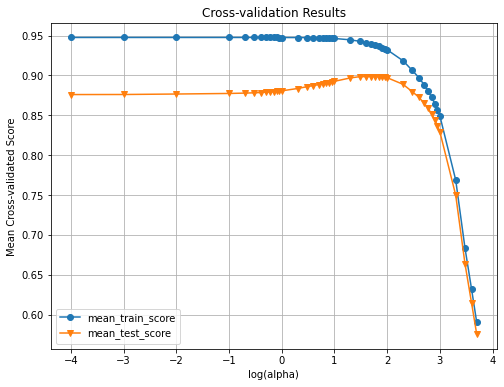

In [78]:


# Get the cross-validation results
alphas = np.array(cv_results.param_alpha).astype(float)
mean_train_scores = cv_results['mean_train_score']
mean_test_scores = cv_results['mean_test_score']

# Plotting the cross-validation results
plt.figure(figsize=(8, 6))
plt.plot(np.log10(alphas), mean_train_scores, marker='o', label='mean_train_score')
plt.plot(np.log10(alphas), mean_test_scores, marker='v', label='mean_test_score')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Cross-validated Score')
plt.title('Cross-validation Results')
plt.grid(True)
plt.legend()
plt.show()

In [79]:


best_alpha, best_score, grid_search = tune_model(X_train_scaled, y_train, alphas, Ridge())

print(f"Best alpha: {best_alpha} \nBest score: {best_score} \nBest estimator: {grid_search.best_estimator_}")

Best alpha: 3.0 
Best score: 0.8969449863756289 
Best estimator: Ridge(alpha=3.0)


In [80]:


# Get the best estimator (model)
best_ridge = grid_search.best_estimator_

# Fit the best model on the entire training data
best_ridge.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
test_score = best_ridge.score(X_test_scaled, y_test)
print(f"Test score with best model: {test_score}")

Test score with best model: 0.8885077868794489


In [81]:


ridge_coefs = pd.DataFrame(best_ridge.coef_, X_train_scaled.columns, columns=["coef"])
ridge_coefs["abs"] = np.abs(ridge_coefs["coef"])

ridge_coefs.sort_values(by="abs", ascending=True)

,coef,abs
HeatingQC_Po,0.000000,0.000000
BedroomAbvGr_3,-36.102447,36.102447
YrSold_2010,154.280821,154.280821
BedroomAbvGr_1,-164.180427,164.180427
Neighborhood_Blueste,188.600799,188.600799
...,...,...
2ndFlrSF,32258.810196,32258.810196
1stFlrSF,35921.140855,35921.140855
TotalBsmtSF,36347.677656,36347.677656
OverallQual_9,36379.117545,36379.117545


In [82]:


ridge_coefs.sort_values(by="coef", ascending=False)

,coef,abs
GrLivArea,50583.841139,50583.841139
OverallQual_9,36379.117545,36379.117545
TotalBsmtSF,36347.677656,36347.677656
1stFlrSF,35921.140855,35921.140855
2ndFlrSF,32258.810196,32258.810196
...,...,...
MSSubClass_90,-14812.041315,14812.041315
KitchenQual_Fa,-15285.281837,15285.281837
OverallQual_5,-15293.023638,15293.023638
OverallQual_3,-20353.613302,20353.613302


In [83]:


len(ridge_coefs)

214

In [84]:


cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012601,0.005814,0.005209,0.002938,0.0001,{'alpha': 0.0001},0.900222,0.803195,0.897239,0.897341,...,0.876813,0.037126,23,0.944921,0.953834,0.946337,0.945873,0.947020,0.947597,0.003192
1,0.007588,0.001174,0.003600,0.000792,0.001,{'alpha': 0.001},0.900256,0.803460,0.897307,0.897394,...,0.876921,0.037045,22,0.944921,0.953834,0.946336,0.945873,0.947020,0.947597,0.003192
2,0.008810,0.000738,0.003589,0.001193,0.01,{'alpha': 0.01},0.900579,0.805979,0.897930,0.897807,...,0.877910,0.036255,21,0.944918,0.953830,0.946329,0.945864,0.947014,0.947591,0.003193
3,0.010793,0.005706,0.003203,0.000395,0.1,{'alpha': 0.1},0.902678,0.821230,0.902253,0.898832,...,0.883719,0.031413,19,0.944790,0.953653,0.946109,0.945655,0.946788,0.947399,0.003194
4,0.008008,0.001426,0.003201,0.000401,0.2,{'alpha': 0.2},0.904013,0.828857,0.905521,0.899059,...,0.887027,0.029232,18,0.944563,0.953370,0.945762,0.945421,0.946454,0.947114,0.003187


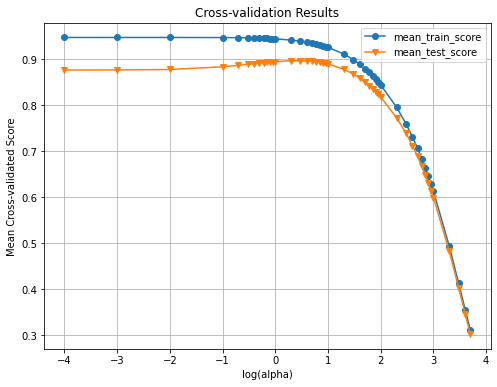

In [85]:

# Get the cross-validation results
alphas = np.array(cv_results.param_alpha).astype(float)
mean_train_scores = cv_results['mean_train_score']
mean_test_scores = cv_results['mean_test_score']

# Plotting the cross-validation results
plt.figure(figsize=(8, 6))
plt.plot(np.log10(alphas), mean_train_scores, marker='o', label='mean_train_score')
plt.plot(np.log10(alphas), mean_test_scores, marker='v', label='mean_test_score')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Cross-validated Score')
plt.title('Cross-validation Results')
plt.grid(True)
plt.legend()
plt.show()

# Q3: in subjective questions

* GrLivArea
* LotArea
* TotalBsmtSF
* YearBuilt
* OverallQual


are the top features in the lasso model.


Dropping these features and building another model

In [86]:


lasso_coefs.sort_values(by="abs", ascending=False)

,coef,abs
GrLivArea,105738.128952,105738.128952
LotArea,57700.018302,57700.018302
TotalBsmtSF,51875.018821,51875.018821
YearBuilt,48613.622214,48613.622214
OverallQual_9,46135.626819,46135.626819
...,...,...
BsmtFullBath_3,0.000000,0.000000
Exterior2nd_Wd Shng,-0.000000,0.000000
Fireplaces_3,0.000000,0.000000
MSZoning_RH,0.000000,0.000000


In [87]:

X_train_scaled.columns[X_train_scaled.columns.str.startswith('OverallQual')]

Index(['OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5',
       'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9',
       'OverallQual_10'],
      dtype='object')

In [88]:

top_5_columns = ["GrLivArea", "LotArea", "TotalBsmtSF", "YearBuilt", 'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5',
       'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9',
       'OverallQual_10']
X_train_scaled_dropped = X_train_scaled.drop(columns=top_5_columns)
X_test_scaled_dropped = X_test_scaled.drop(columns=top_5_columns)

In [89]:

best_alpha, best_score, grid_search = tune_model(X_train_scaled_dropped, y_train, alphas, Lasso())

In [90]:

# Get the best estimator (model)
best_lasso1 = grid_search.best_estimator_

# Fit the best model on the entire training data
best_lasso1.fit(X_train_scaled_dropped, y_train)

# Evaluate the best model on the test set
test_score = best_lasso1.score(X_test_scaled_dropped, y_test)
print(f"Test score with best model: {test_score}")

Test score with best model: 0.874712762114531


In [91]:

lasso_coefs1 = pd.DataFrame(best_lasso1.coef_, X_train_scaled_dropped.columns, columns=["coef"])
lasso_coefs1["abs"] = np.abs(lasso_coefs1["coef"])

lasso_coefs1.sort_values(by="abs", ascending=False)

,coef,abs
1stFlrSF,128275.063645,128275.063645
2ndFlrSF,72573.561066,72573.561066
BsmtFinSF1,35424.994653,35424.994653
Neighborhood_StoneBr,30822.598155,30822.598155
OverallCond_3,-26793.154748,26793.154748
...,...,...
Exterior1st_ImStucc,-0.000000,0.000000
FireplaceQu_Fa,0.000000,0.000000
Exterior1st_CemntBd,0.000000,0.000000
Exterior1st_CBlock,-0.000000,0.000000


## Best features avoiding top 5 features

Now the top 5 features are 

* 1stFlrSF
* 2ndFlrSF
* BsmtFinSF1
* Neighborhood_StoneBr
* OverallCond


## Model using handpicked features

* Some features were handpicked based on domain knowledge and based on different models created
* There are only 24 handpicked features

In [92]:

handpicked_features = ['GrLivArea',
 'GarageFinish',
 'MSSubClass',
 '1stFlrSF',
 'Exterior1st',
 'LotFrontage',
 'GarageCars',
 'BsmtFinType1',
 'FireplaceQu',
 'BsmtFullBath',
 'TotRmsAbvGrd',
 'GarageType',
 'BsmtFinSF1',
 'YearBuilt',
 '2ndFlrSF',
 'Foundation',
 'Exterior2nd',
 'MSZoning',
 'LotArea',
 'TotalBsmtSF',
 'OverallQual',
 'OverallCond',
 'Neighborhood',
 'BsmtQual',
'SalePrice']
handpicked_features

['GrLivArea',
 'GarageFinish',
 'MSSubClass',
 '1stFlrSF',
 'Exterior1st',
 'LotFrontage',
 'GarageCars',
 'BsmtFinType1',
 'FireplaceQu',
 'BsmtFullBath',
 'TotRmsAbvGrd',
 'GarageType',
 'BsmtFinSF1',
 'YearBuilt',
 '2ndFlrSF',
 'Foundation',
 'Exterior2nd',
 'MSZoning',
 'LotArea',
 'TotalBsmtSF',
 'OverallQual',
 'OverallCond',
 'Neighborhood',
 'BsmtQual',
 'SalePrice']

In [93]:
X_train_scaled, X_test_scaled, y_train, y_test = get_data(df[handpicked_features])

best_alpha, best_score, grid_search = tune_model(X_train_scaled, y_train, alphas, Lasso())

print(f"Best alpha: {best_alpha} \nBest score: {best_score} \nBest estimator: {grid_search.best_estimator_}")

# Get the best estimator (model)
best_lasso = grid_search.best_estimator_

# Fit the best model on the entire training data
best_lasso.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
test_score = best_lasso.score(X_test_scaled, y_test)
print(f"Test score with best model: {test_score}")

lasso_coefs = pd.DataFrame(best_lasso.coef_, X_train_scaled.columns, columns=["coef"])
lasso_coefs["abs"] = np.abs(lasso_coefs["coef"])

lasso_coefs.sort_values(by="abs", ascending=True)

y_pred = best_lasso.predict(X_test_scaled)
r2_score_value = r2_score(y_pred, y_test)

print(f"r2 score value is {r2_score_value}")

Best alpha: 70.0 
Best score: 0.8952296467517445 
Best estimator: Lasso(alpha=70.0)
Test score with best model: 0.8792275840769046
r2 score value is 0.8577556220959375


In [94]:

lasso_coefs.sort_values(by="abs", ascending=True).head(63)

,coef,abs
MSSubClass_180,-0.0,0.0
Exterior1st_AsphShn,-0.0,0.0
FireplaceQu_Fa,0.0,0.0
BsmtFullBath_3,0.0,0.0
Exterior1st_BrkComm,-0.0,0.0
...,...,...
Exterior2nd_VinylSd,0.0,0.0
Exterior2nd_Other,0.0,0.0
Exterior2nd_Plywood,0.0,0.0
Exterior2nd_BrkFace,0.0,0.0


* Lasso has made 63 features as 0 (63 features because of dummy encoding)
* Below are the 10 most important features

In [95]:

lasso_coefs.sort_values(by="abs", ascending=False).head(10)

,coef,abs
GrLivArea,118792.499602,118792.499602
LotArea,78179.075655,78179.075655
OverallQual_9,63336.617078,63336.617078
YearBuilt,58220.508981,58220.508981
TotalBsmtSF,54951.215297,54951.215297
OverallQual_8,32037.742585,32037.742585
BsmtFinSF1,30837.379688,30837.379688
OverallCond_3,-29781.116347,29781.116347
Neighborhood_Crawfor,26321.863829,26321.863829
Neighborhood_StoneBr,20352.562151,20352.562151


Q1: subjective question

In [96]:

# Fit the best model on the entire training data

print(f"Best alpha and best alpha * 2: {best_alpha} and {best_alpha * 2}")
best_lasso = Lasso(best_alpha * 2)
best_lasso.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
test_score = best_lasso.score(X_test_scaled, y_test)
print(f"Test score with best model: {test_score}")

lasso_coefs = pd.DataFrame(best_lasso.coef_, X_train_scaled.columns, columns=["coef"])
lasso_coefs["abs"] = np.abs(lasso_coefs["coef"])

lasso_coefs.sort_values(by="abs", ascending=True)

y_pred = best_lasso.predict(X_test_scaled)
r2_score_value = r2_score(y_pred, y_test)

print(f"r2 score value is {r2_score_value}")
display(lasso_coefs.sort_values(by="abs", ascending=False).head(10))
display(lasso_coefs.sort_values(by="abs", ascending=True).head(10).index)

Best alpha and best alpha * 2: 70.0 and 140.0
Test score with best model: 0.8716230781720913
r2 score value is 0.8456236227432332


,coef,abs
GrLivArea,123282.956339,123282.956339
OverallQual_9,66154.055459,66154.055459
LotArea,55786.312504,55786.312504
YearBuilt,53482.598325,53482.598325
TotalBsmtSF,51601.700865,51601.700865
OverallQual_8,34010.547120,34010.547120
BsmtFinSF1,32896.769563,32896.769563
OverallCond_3,-27202.210843,27202.210843
Neighborhood_Crawfor,25882.234832,25882.234832
GarageCars_3,20915.431878,20915.431878


Index(['MSSubClass_180', 'Exterior1st_AsphShn', 'Foundation_Wood',
       'Foundation_Stone', 'Foundation_Slab', 'Foundation_CBlock',
       'BsmtQual_None', 'OverallQual_10', 'OverallQual_6', 'OverallQual_2'],
      dtype='object')

In [97]:

X_train_scaled, X_test_scaled, y_train, y_test = get_data(df[handpicked_features])

best_alpha, best_score, grid_search = tune_model(X_train_scaled, y_train, alphas, Ridge())

print(f"Best alpha: {best_alpha} \nBest score: {best_score} \nBest estimator: {grid_search.best_estimator_}")

# Get the best estimator (model)
best_ridge = grid_search.best_estimator_

# Fit the best model on the entire training data
best_ridge.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
test_score = best_ridge.score(X_test_scaled, y_test)
print(f"Test score with best model: {test_score}")

ridge_coefs = pd.DataFrame(best_ridge.coef_, X_train_scaled.columns, columns=["coef"])
ridge_coefs["abs"] = np.abs(ridge_coefs["coef"])

ridge_coefs.sort_values(by="abs", ascending=True)

y_pred = best_ridge.predict(X_test_scaled)
r2_score_value = r2_score(y_pred, y_test)

print(f"r2 score value is {r2_score_value}")

display(ridge_coefs.sort_values(by="abs", ascending=False).head(10))
display(ridge_coefs.sort_values(by="abs", ascending=True).head(10).index)

Best alpha: 2.0 
Best score: 0.8936691948756135 
Best estimator: Ridge(alpha=2.0)
Test score with best model: 0.8877776445641111
r2 score value is 0.8704199901756525


,coef,abs
GrLivArea,61908.288730,61908.288730
LotArea,51258.471251,51258.471251
1stFlrSF,49812.170935,49812.170935
TotalBsmtSF,48353.975935,48353.975935
OverallQual_9,46700.881848,46700.881848
YearBuilt,43681.151004,43681.151004
2ndFlrSF,33158.636560,33158.636560
OverallCond_3,-27631.250748,27631.250748
BsmtFinSF1,27056.138616,27056.138616
Neighborhood_Crawfor,23204.477973,23204.477973


Index(['Exterior2nd_HdBoard', 'GarageType_Detchd', 'MSSubClass_70',
       'Neighborhood_CollgCr', 'BsmtFinType1_BLQ', 'BsmtFinType1_Unf',
       'Exterior1st_HdBoard', 'MSSubClass_40', 'MSSubClass_80',
       'Exterior1st_AsphShn'],
      dtype='object')

In [98]:

print(f"Best alpha and best alpha * 2: {best_alpha} and {best_alpha * 2}")
best_ridge = Ridge(best_alpha * 2)
# Fit the best model on the entire training data
best_ridge.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
test_score = best_ridge.score(X_test_scaled, y_test)
print(f"Test score with best model: {test_score}")

ridge_coefs = pd.DataFrame(best_ridge.coef_, X_train_scaled.columns, columns=["coef"])
ridge_coefs["abs"] = np.abs(ridge_coefs["coef"])

ridge_coefs.sort_values(by="abs", ascending=True)

y_pred = best_ridge.predict(X_test_scaled)
r2_score_value = r2_score(y_pred, y_test)

print(f"r2 score value is {r2_score_value}")

display(ridge_coefs.sort_values(by="abs", ascending=False).head(10))
display(ridge_coefs.sort_values(by="abs", ascending=True).head(10).index)

Best alpha and best alpha * 2: 2.0 and 4.0
Test score with best model: 0.8833030865584661
r2 score value is 0.8628388676565153


,coef,abs
GrLivArea,55850.411328,55850.411328
TotalBsmtSF,45564.557472,45564.557472
1stFlrSF,44858.808285,44858.808285
OverallQual_9,44420.371799,44420.371799
LotArea,36085.480459,36085.480459
YearBuilt,34726.514379,34726.514379
2ndFlrSF,27761.648650,27761.648650
BsmtFinSF1,27378.960395,27378.960395
OverallCond_3,-25397.527009,25397.527009
Neighborhood_Crawfor,21566.996548,21566.996548


Index(['Exterior1st_WdShing', 'Neighborhood_CollgCr', 'Exterior2nd_VinylSd',
       'GarageType_Detchd', 'Exterior2nd_HdBoard', 'MSSubClass_80',
       'FireplaceQu_TA', 'TotRmsAbvGrd_6', 'BsmtFinType1_BLQ',
       'Foundation_Stone'],
      dtype='object')